In [1]:
!pip install -q catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 6.4 MB/s eta 0:00:00


In [2]:
!pip install -q sklearn-lvq

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.impute import SimpleImputer
from catboost import CatBoostClassifier
from sklearn_lvq import GlvqModel
from sklearn.inspection import permutation_importance
import warnings
warnings.filterwarnings('ignore')


In [4]:
# Load the datasets with correct column mapping
def load_and_preprocess_data():
    # Load datasets
    df1 = pd.read_csv('heart.csv')
    df2 = pd.read_csv('heart_analysis.csv')

    # Print original shapes
    print("Original dataset shapes:")
    print("Heart.csv shape:", df1.shape)
    print("Heart_analysis.csv shape:", df2.shape)

    # Create column mapping dictionary
    column_mapping = {
        'age': 'Age',
        'sex': 'Sex',
        'cp': 'ChestPainType',
        'trtbps': 'RestingBP',
        'chol': 'Cholesterol',
        'fbs': 'FastingBS',
        'restecg': 'RestingECG',
        'thalachh': 'MaxHR',
        'exng': 'ExerciseAngina',
        'oldpeak': 'Oldpeak',
        'slp': 'ST_Slope',
        'output': 'HeartDisease'
    }

    # Rename columns in df2 to match df1
    df2 = df2.rename(columns=column_mapping)

    # Select common columns that we want to use
    columns_to_use = ['Age', 'Sex', 'ChestPainType', 'RestingBP', 'Cholesterol',
                      'FastingBS', 'RestingECG', 'MaxHR', 'ExerciseAngina',
                      'Oldpeak', 'ST_Slope', 'HeartDisease']

    # Keep only the columns we want to use from df2
    df2 = df2[columns_to_use]

    # Combine datasets
    df = pd.concat([df1, df2], ignore_index=True)

    # Print final shape
    print("\nFinal combined dataset shape:", df.shape)
    print("\nFinal columns:", df.columns.tolist())

    return df

# Load the data
df = load_and_preprocess_data()

# Display first few rows and data info
print("\nFirst few rows of combined dataset:")
print(df.head())
print("\nDataset info:")
df.info()

# Now let's check for any missing values
print("\nMissing values:")
print(df.isnull().sum())

# Display basic statistics
print("\nBasic statistics:")
print(df.describe())


Original dataset shapes:
Heart.csv shape: (918, 12)
Heart_analysis.csv shape: (303, 14)

Final combined dataset shape: (1221, 12)

Final columns: ['Age', 'Sex', 'ChestPainType', 'RestingBP', 'Cholesterol', 'FastingBS', 'RestingECG', 'MaxHR', 'ExerciseAngina', 'Oldpeak', 'ST_Slope', 'HeartDisease']

First few rows of combined dataset:
   Age Sex ChestPainType  RestingBP  Cholesterol  FastingBS RestingECG  MaxHR  \
0   40   M           ATA        140          289          0     Normal    172   
1   49   F           NAP        160          180          0     Normal    156   
2   37   M           ATA        130          283          0         ST     98   
3   48   F           ASY        138          214          0     Normal    108   
4   54   M           NAP        150          195          0     Normal    122   

  ExerciseAngina  Oldpeak ST_Slope  HeartDisease  
0              N      0.0       Up             0  
1              N      1.0     Flat             1  
2              N      0.

In [5]:
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


# **Checking Outliers**

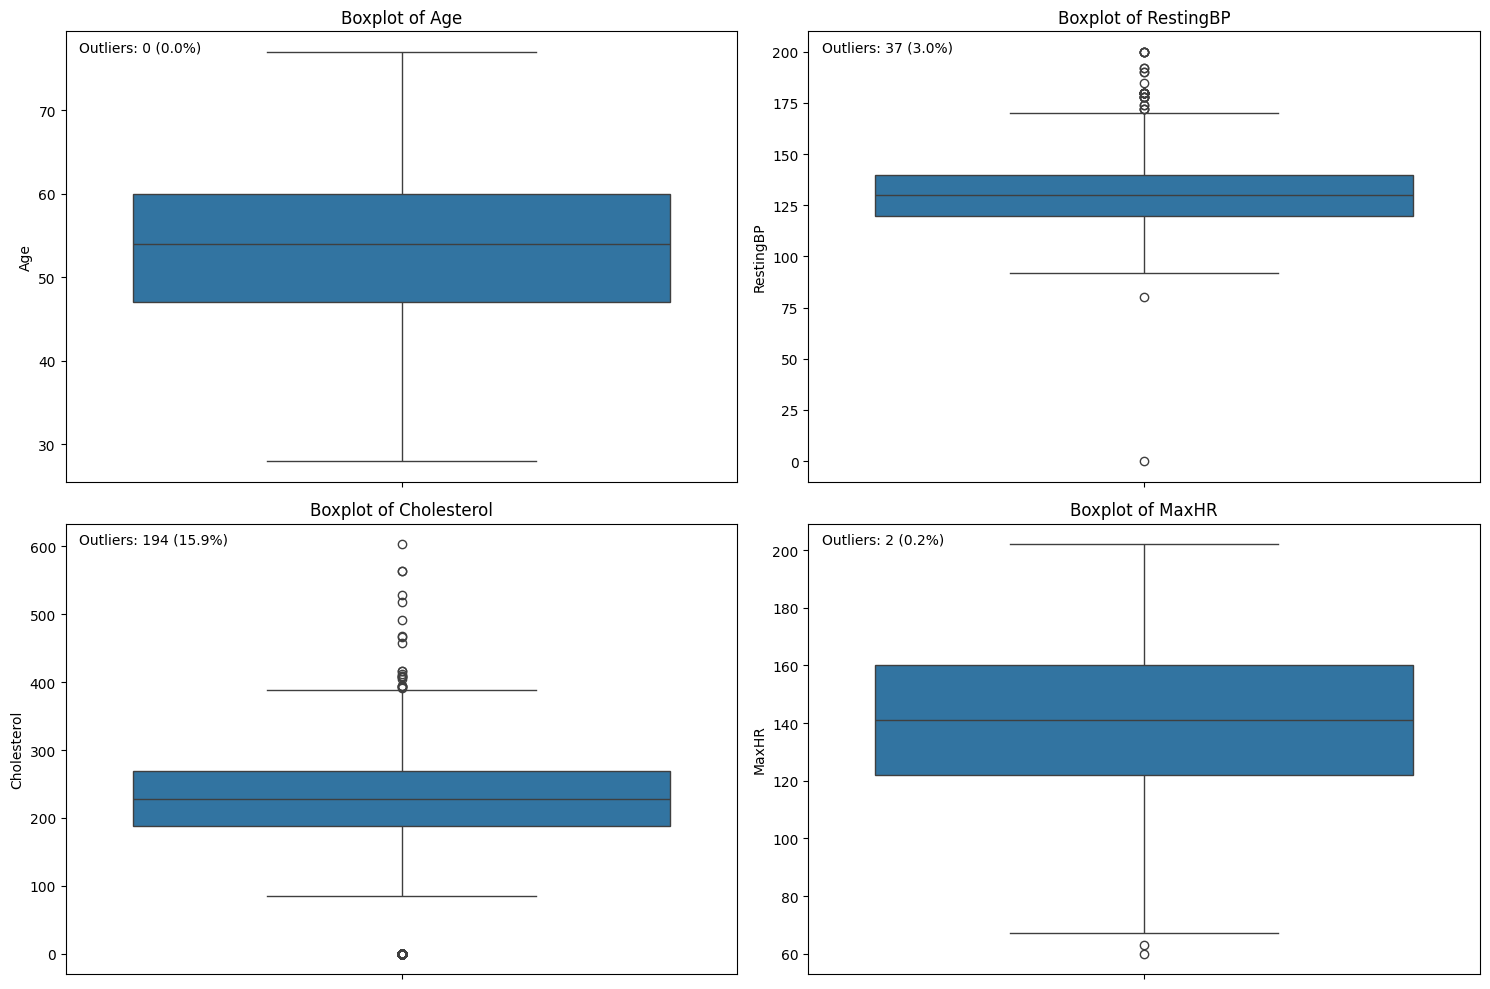

In [6]:
# Outlier Analysis
def plot_outliers():
    plt.figure(figsize=(15, 10))
    numeric_cols = ['Age', 'RestingBP', 'Cholesterol', 'MaxHR']

    for i, column in enumerate(numeric_cols, 1):
        plt.subplot(2, 2, i)
        sns.boxplot(data=df, y=column)
        plt.title(f'Boxplot of {column}')

        # Calculate and display outlier percentages
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        outliers = df[(df[column] < (Q1 - 1.5 * IQR)) | (df[column] > (Q3 + 1.5 * IQR))][column]
        outlier_percentage = (len(outliers) / len(df)) * 100
        plt.text(0.02, 0.98, f'Outliers: {len(outliers)} ({outlier_percentage:.1f}%)',
                transform=plt.gca().transAxes, verticalalignment='top')

    plt.tight_layout()
    plt.show()

# Plot outliers
plot_outliers()


# **Handle Outliers**

In [7]:
# Handle Cholesterol outliers (specifically the zero values)
cholesterol_mask = df['Cholesterol'] == 0
mean_cholesterol = df[~cholesterol_mask]['Cholesterol'].mean()
df.loc[cholesterol_mask, 'Cholesterol'] = mean_cholesterol

# Handle RestingBP outliers (specifically the zero values)
restingbp_mask = df['RestingBP'] == 0
mean_restingbp = df[~restingbp_mask]['RestingBP'].mean()
df.loc[restingbp_mask, 'RestingBP'] = mean_restingbp

# Let's verify the changes
print("\nAfter handling zero values:")
print("Cholesterol zeros:", (df['Cholesterol'] == 0).sum())
print("RestingBP zeros:", (df['RestingBP'] == 0).sum())


After handling zero values:
Cholesterol zeros: 0
RestingBP zeros: 0


# **Label Encoding**

In [8]:
# Encode categorical variables first
from sklearn.preprocessing import LabelEncoder

# Create a copy of the dataframe to avoid modifying the original
df_encoded = df.copy()

# List of categorical columns
categorical_columns = ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']

# Convert all values in categorical columns to strings first
for column in categorical_columns:
    df_encoded[column] = df_encoded[column].astype(str)

# Print unique values before encoding
print("Unique values before encoding:")
for column in categorical_columns:
    print(f"\n{column}:", df_encoded[column].unique())

# Encode each categorical column
le = LabelEncoder()
for column in categorical_columns:
    df_encoded[column] = le.fit_transform(df_encoded[column])

# Print unique values after encoding
print("\nUnique values after encoding:")
for column in categorical_columns:
    print(f"\n{column}:", df_encoded[column].unique())

Unique values before encoding:

Sex: ['M' 'F' '1' '0']

ChestPainType: ['ATA' 'NAP' 'ASY' 'TA' '3' '2' '1' '0']

RestingECG: ['Normal' 'ST' 'LVH' '0' '1' '2']

ExerciseAngina: ['N' 'Y' '0' '1']

ST_Slope: ['Up' 'Flat' 'Down' '0' '2' '1']

Unique values after encoding:

Sex: [3 2 1 0]

ChestPainType: [5 6 4 7 3 2 1 0]

RestingECG: [4 5 3 0 1 2]

ExerciseAngina: [2 3 0 1]

ST_Slope: [5 4 3 0 2 1]


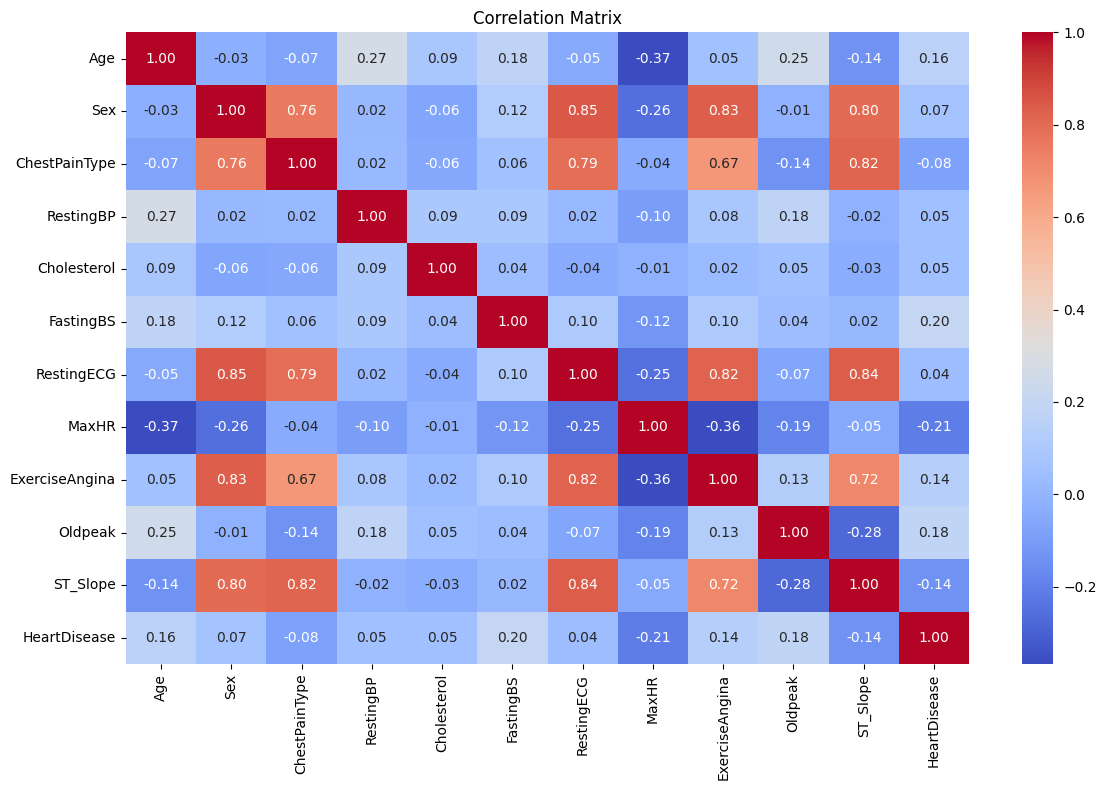

In [9]:
plt.figure(figsize=(12, 8))
sns.heatmap(df_encoded.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.tight_layout()
plt.show()

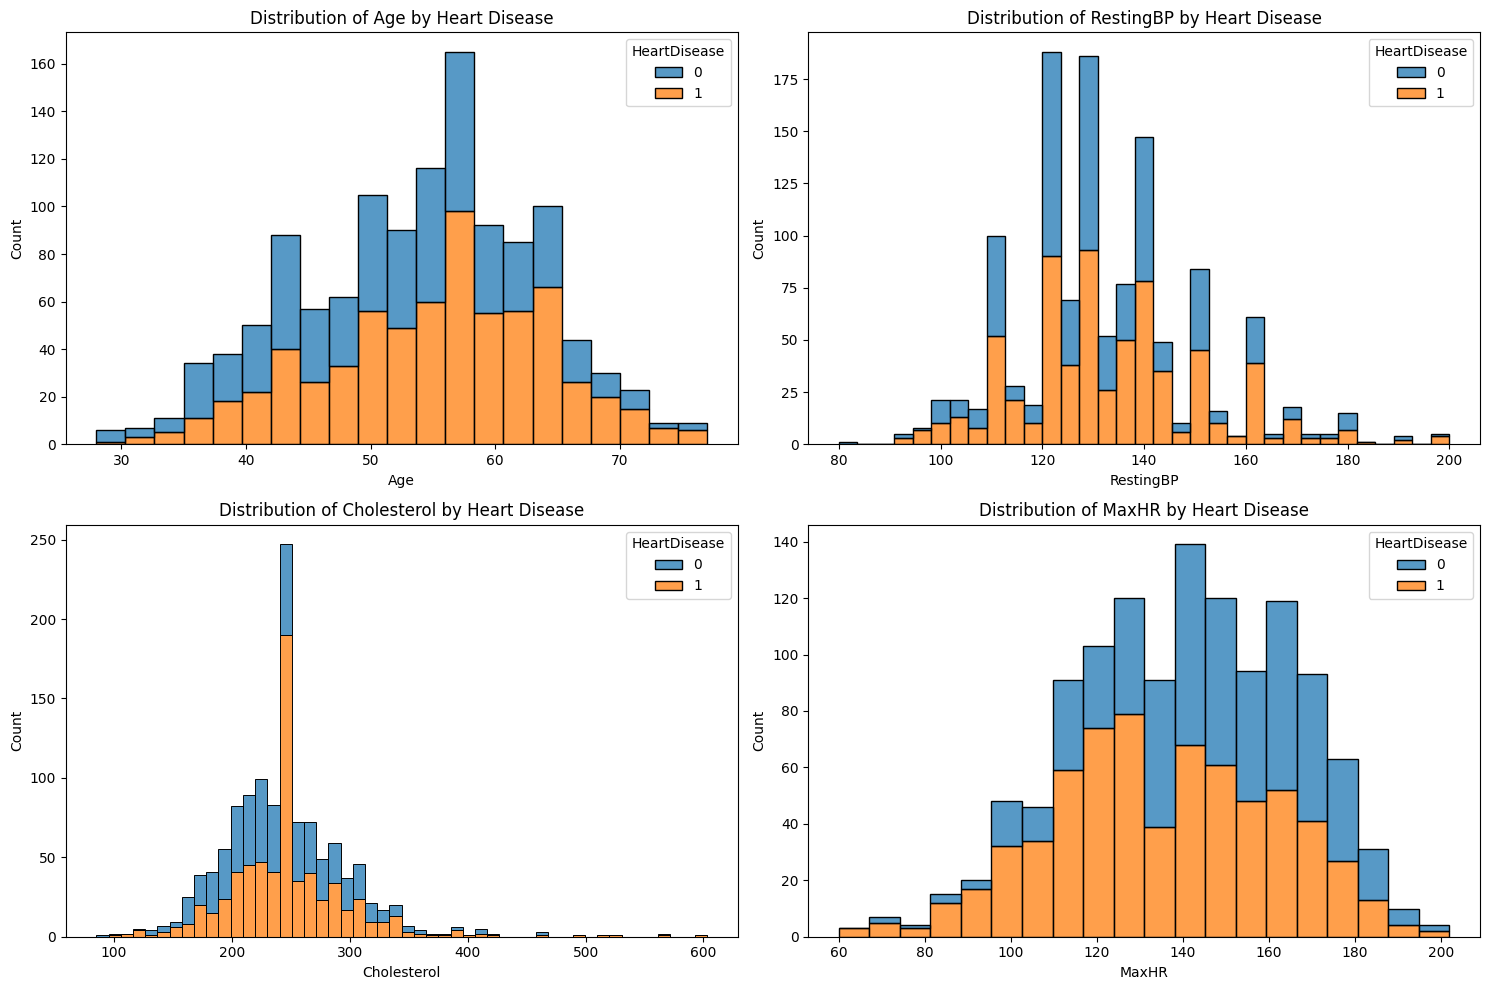

In [10]:
# Distribution plots for numerical features
numerical_features = ['Age', 'RestingBP', 'Cholesterol', 'MaxHR']
plt.figure(figsize=(15, 10))
for i, feature in enumerate(numerical_features, 1):
    plt.subplot(2, 2, i)
    sns.histplot(data=df, x=feature, hue='HeartDisease', multiple="stack")
    plt.title(f'Distribution of {feature} by Heart Disease')
plt.tight_layout()
plt.show()

# **Prepare Data and Modeling**

In [11]:
# Separate features and target
X = df_encoded.drop('HeartDisease', axis=1)
y = df_encoded['HeartDisease']

# Print shapes to verify
print("X shape:", X.shape)
print("y shape:", y.shape)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Print shapes after splitting and scaling
print("\nAfter splitting:")
print("X_train_scaled shape:", X_train_scaled.shape)
print("X_test_scaled shape:", X_test_scaled.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X shape: (1221, 11)
y shape: (1221,)

After splitting:
X_train_scaled shape: (976, 11)
X_test_scaled shape: (245, 11)
y_train shape: (976,)
y_test shape: (245,)


In [12]:
!pip install -q minisom  # We'll use SOM (Self-Organizing Map) as an alternative to LVQ

  Preparing metadata (setup.py) ... done


In [13]:
from minisom import MiniSom
from catboost import CatBoostClassifier
from sklearn_lvq import GlvqModel

# Initialize models
catboost = CatBoostClassifier(verbose=False)
lvq = GlvqModel(prototypes_per_class=3, max_iter=2500, random_state=42)

# Convert data to the correct format
X_train_scaled_2d = np.array(X_train_scaled)
X_test_scaled_2d = np.array(X_test_scaled)
y_train_1d = np.array(y_train)
y_test_1d = np.array(y_test)

# Make sure arrays have correct dimensions
print("Training data shapes:")
print("X_train_scaled shape:", X_train_scaled_2d.shape)
print("y_train shape:", y_train_1d.shape)

Training data shapes:
X_train_scaled shape: (976, 11)
y_train shape: (976,)


In [14]:
class CustomLVQ:
    def __init__(self, n_prototypes_per_class=3, learning_rate=0.01, n_iterations=100, random_state=42):
        self.n_prototypes_per_class = n_prototypes_per_class
        self.learning_rate = learning_rate
        self.n_iterations = n_iterations
        self.random_state = random_state
        self.prototypes = None
        self.prototype_labels = None

    def _initialize_prototypes(self, X, y):
        np.random.seed(self.random_state)
        n_features = X.shape[1]
        unique_classes = np.unique(y)

        prototypes = []
        prototype_labels = []

        # Initialize prototypes for each class
        for class_label in unique_classes:
            class_samples = X[y == class_label]

            # Randomly select samples as initial prototypes
            indices = np.random.choice(len(class_samples),
                                     size=self.n_prototypes_per_class,
                                     replace=False)

            class_prototypes = class_samples[indices]
            prototypes.extend(class_prototypes)
            prototype_labels.extend([class_label] * self.n_prototypes_per_class)

        self.prototypes = np.array(prototypes)
        self.prototype_labels = np.array(prototype_labels)

    def _find_nearest_prototype(self, sample):
        distances = np.linalg.norm(self.prototypes - sample, axis=1)
        return np.argmin(distances)

    def fit(self, X, y):
        # Convert pandas Series to numpy array if needed
        if hasattr(y, 'values'):
            y = y.values
        X = np.array(X)

        # Initialize prototypes
        self._initialize_prototypes(X, y)

        # Training iterations
        for _ in range(self.n_iterations):
            # Shuffle training data
            indices = np.random.permutation(len(X))
            X_shuffled = X[indices]
            y_shuffled = y[indices]

            # Update prototypes
            for i in range(len(X_shuffled)):
                sample = X_shuffled[i]
                label = y_shuffled[i]

                # Find nearest prototype
                nearest_idx = self._find_nearest_prototype(sample)
                nearest_proto = self.prototypes[nearest_idx]
                proto_label = self.prototype_labels[nearest_idx]

                # Update prototype
                if proto_label == label:
                    # Move prototype closer to sample
                    self.prototypes[nearest_idx] += self.learning_rate * (sample - nearest_proto)
                else:
                    # Move prototype away from sample
                    self.prototypes[nearest_idx] -= self.learning_rate * (sample - nearest_proto)

        return self

    def predict(self, X):
        X = np.array(X)
        predictions = []
        for sample in X:
            nearest_idx = self._find_nearest_prototype(sample)
            predictions.append(self.prototype_labels[nearest_idx])
        return np.array(predictions)

    def predict_proba(self, X):
        X = np.array(X)
        probas = np.zeros((len(X), 2))  # For binary classification
        for i, sample in enumerate(X):
            distances = np.linalg.norm(self.prototypes - sample, axis=1)

            # Convert distances to probabilities using softmax
            exp_distances = np.exp(-distances)
            class_0_dist = np.sum(exp_distances[self.prototype_labels == 0])
            class_1_dist = np.sum(exp_distances[self.prototype_labels == 1])
            total = class_0_dist + class_1_dist

            probas[i, 0] = class_0_dist / total
            probas[i, 1] = class_1_dist / total

        return probas

# Print shapes for verification
print("Data shapes:")
print("X_train_scaled shape:", X_train_scaled.shape)
print("y_train shape:", y_train.shape)


Data shapes:
X_train_scaled shape: (976, 11)
y_train shape: (976,)



Training CatBoost...
CatBoost training completed successfully

Training LVQ...
LVQ training completed successfully

Final Results:
CatBoost probability output shape: (245,)
LVQ probability output shape: (245,)

CatBoost Metrics:
Accuracy: 0.8857
Precision: 0.8718
Recall: 0.9444
F1 Score: 0.9067

LVQ Metrics:
Accuracy: 0.8041
Precision: 0.8582
Recall: 0.7986
F1 Score: 0.8273


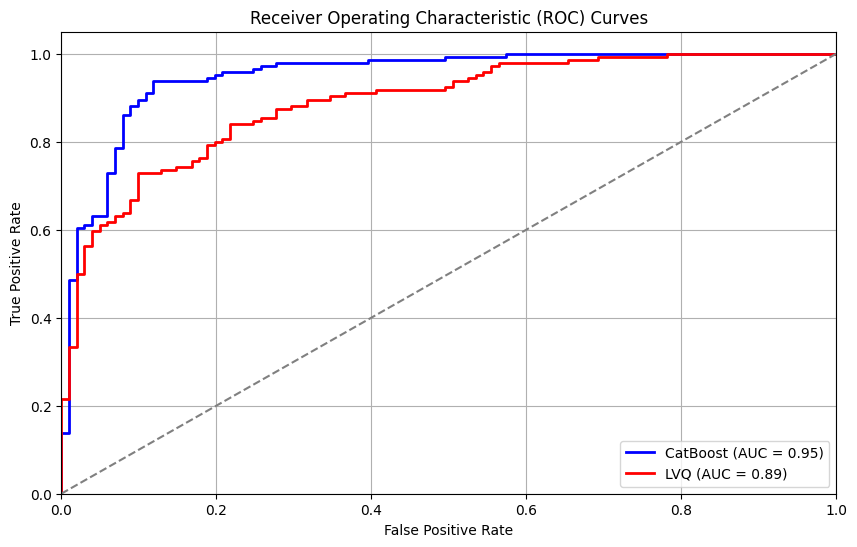

In [15]:
# Initialize models
catboost = CatBoostClassifier(verbose=False)
lvq = CustomLVQ(n_prototypes_per_class=3,
                learning_rate=0.01,
                n_iterations=1000,
                random_state=42)

models = {
    'CatBoost': catboost,
    'LVQ': lvq
}

# Train models and get predictions
results = {}
probabilities = {}

for name, model in models.items():
    print(f"\nTraining {name}...")
    try:
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
        probabilities[name] = model.predict_proba(X_test_scaled)[:, 1]
        results[name] = y_pred
        print(f"{name} training completed successfully")

    except Exception as e:
        print(f"Error training {name}: {str(e)}")
        import traceback
        traceback.print_exc()

# Print results and metrics
print("\nFinal Results:")
for name in probabilities.keys():
    print(f"{name} probability output shape:", probabilities[name].shape)

# Calculate metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

for name in results.keys():
    print(f"\n{name} Metrics:")
    y_pred = results[name]
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print(f"Precision: {precision_score(y_test, y_pred):.4f}")
    print(f"Recall: {recall_score(y_test, y_pred):.4f}")
    print(f"F1 Score: {f1_score(y_test, y_pred):.4f}")

# Plot ROC curves
plt.figure(figsize=(10, 6))
colors = ['blue', 'red']

for (name, prob), color in zip(probabilities.items(), colors):
    fpr, tpr, _ = roc_curve(y_test, prob)
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, color=color, lw=2,
             label=f'{name} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# **Feature** Importance Analysis

In [16]:
def calculate_feature_importance_lvq(model, X, y, feature_names):
    """Custom feature importance calculation for LVQ"""
    importance_scores = []
    X = np.array(X)
    y = np.array(y)
    baseline_pred = model.predict(X)
    baseline_accuracy = np.mean(baseline_pred == y)

    for i in range(X.shape[1]):
        # Create a copy of the data
        X_permuted = X.copy()
        # Permute one feature
        np.random.shuffle(X_permuted[:, i])
        # Get predictions with permuted feature
        permuted_pred = model.predict(X_permuted)
        # Calculate accuracy drop
        permuted_accuracy = np.mean(permuted_pred == y)
        # Importance is the drop in accuracy
        importance = baseline_accuracy - permuted_accuracy
        importance_scores.append(importance)

    return importance_scores

In [17]:
def calculate_feature_importance(model, X, y, feature_names, model_name):
    """Calculate feature importance for both CatBoost and LVQ models"""
    importance_scores = []
    X = np.array(X)
    y = np.array(y)

    if model_name == 'CatBoost':
        # Get built-in feature importance for CatBoost
        importance_scores = model.get_feature_importance()
    else:
        # Calculate permutation importance for LVQ
        baseline_pred = model.predict(X)
        baseline_accuracy = np.mean(baseline_pred == y)

        for i in range(X.shape[1]):
            # Create a copy of the data
            X_permuted = X.copy()
            # Permute one feature
            np.random.shuffle(X_permuted[:, i])
            # Get predictions with permuted feature
            permuted_pred = model.predict(X_permuted)
            # Calculate accuracy drop
            permuted_accuracy = np.mean(permuted_pred == y)
            # Importance is the drop in accuracy
            importance = baseline_accuracy - permuted_accuracy
            importance_scores.append(importance)

    # Create DataFrame with results
    feature_importance = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importance_scores
    })

    # Sort by importance
    feature_importance = feature_importance.sort_values('Importance', ascending=False)

    # Plot
    plt.figure(figsize=(12, 6))
    sns.barplot(data=feature_importance, x='Importance', y='Feature')
    plt.title(f'Feature Importance - {model_name}')
    plt.xlabel('Importance Score')
    plt.ylabel('Features')
    plt.tight_layout()
    plt.show()

    # Print numerical values
    print(f"\n{model_name} Feature Importance:")
    for idx, row in feature_importance.iterrows():
        print(f"{row['Feature']}: {row['Importance']:.4f}")

    return feature_importance

In [18]:
def plot_feature_importance(importance_scores, feature_names, model_name):
    # Create DataFrame for plotting
    feature_importance = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importance_scores
    })

    # Sort by importance
    feature_importance = feature_importance.sort_values('Importance', ascending=False)

    # Plot
    plt.figure(figsize=(12, 6))
    sns.barplot(data=feature_importance, x='Importance', y='Feature')
    plt.title(f'Feature Importance - {model_name}')
    plt.xlabel('Importance Score (Accuracy Drop)')
    plt.ylabel('Features')
    plt.tight_layout()
    plt.show()

    # Print numerical values
    print(f"\n{model_name} Feature Importance:")
    for idx, row in feature_importance.iterrows():
        print(f"{row['Feature']}: {row['Importance']:.4f}")

    return feature_importance

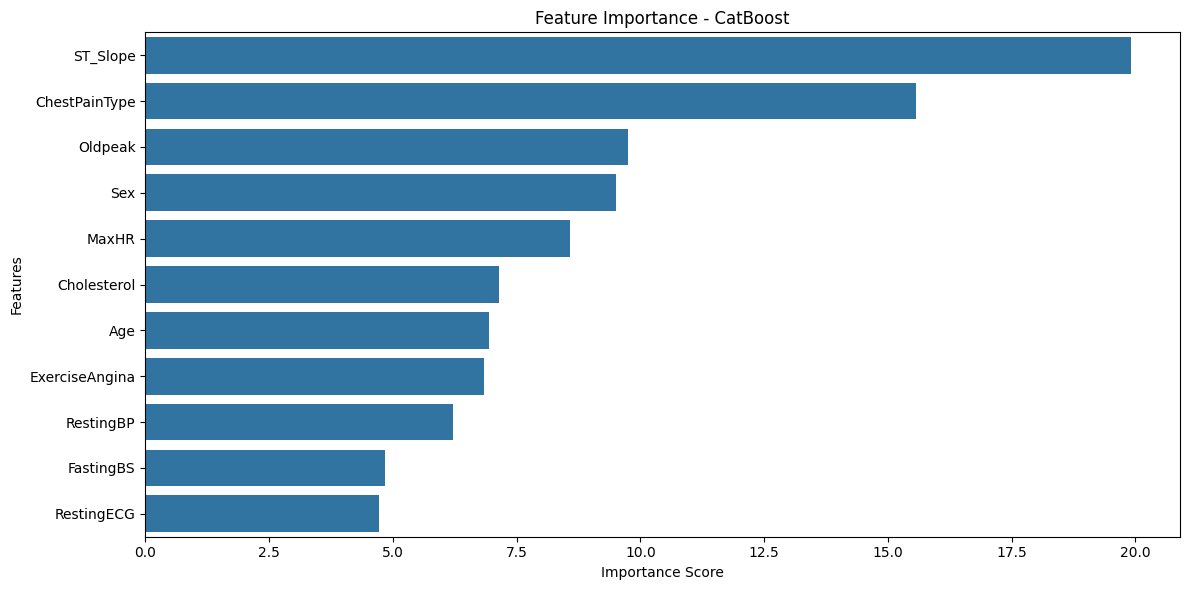


CatBoost Feature Importance:
ST_Slope: 19.9039
ChestPainType: 15.5736
Oldpeak: 9.7387
Sex: 9.5137
MaxHR: 8.5690
Cholesterol: 7.1466
Age: 6.9489
ExerciseAngina: 6.8388
RestingBP: 6.2156
FastingBS: 4.8404
RestingECG: 4.7108


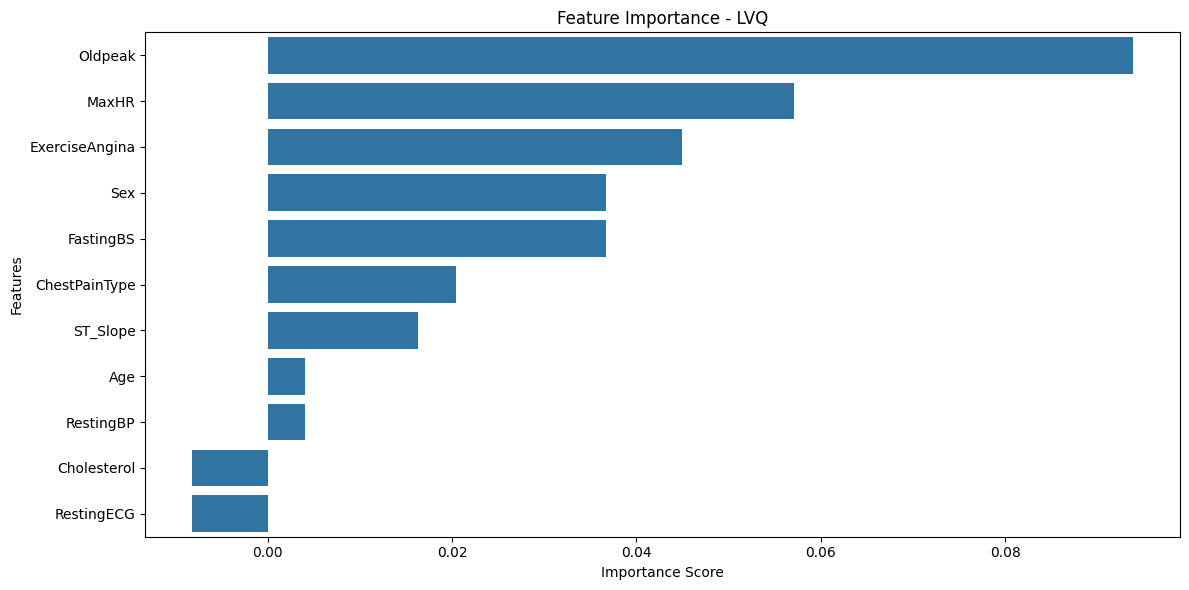


LVQ Feature Importance:
Oldpeak: 0.0939
MaxHR: 0.0571
ExerciseAngina: 0.0449
Sex: 0.0367
FastingBS: 0.0367
ChestPainType: 0.0204
ST_Slope: 0.0163
Age: 0.0041
RestingBP: 0.0041
Cholesterol: -0.0082
RestingECG: -0.0082


In [19]:
# Get feature names
feature_names = X_train.columns.tolist()

# Calculate and plot feature importance for both models
catboost_importance = calculate_feature_importance(
    models['CatBoost'],
    X_test_scaled,
    y_test,
    feature_names,
    'CatBoost'
)

lvq_importance = calculate_feature_importance(
    models['LVQ'],
    X_test_scaled,
    y_test,
    feature_names,
    'LVQ'
)


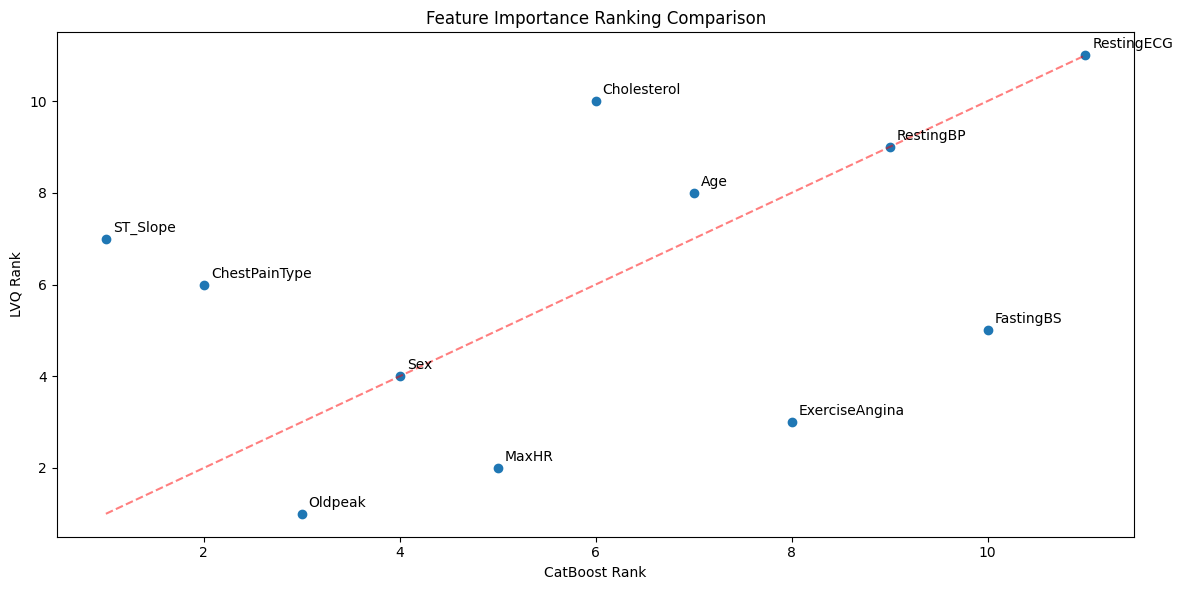


Features with Most Different Rankings:
       Feature  CatBoost_Rank  LVQ_Rank  Rank_Difference
      ST_Slope              1         7                6
ExerciseAngina              8         3                5
     FastingBS             10         5                5
 ChestPainType              2         6                4
   Cholesterol              6        10                4


In [20]:
#Compare feature rankings between models
def compare_feature_rankings(catboost_importance, lvq_importance):
    # Get rankings for both models
    catboost_ranks = catboost_importance.copy()
    catboost_ranks['CatBoost_Rank'] = range(1, len(catboost_ranks) + 1)

    lvq_ranks = lvq_importance.copy()
    lvq_ranks['LVQ_Rank'] = range(1, len(lvq_ranks) + 1)

    # Merge rankings
    comparison = pd.merge(
        catboost_ranks[['Feature', 'CatBoost_Rank']],
        lvq_ranks[['Feature', 'LVQ_Rank']],
        on='Feature'
    )

    # Calculate rank difference
    comparison['Rank_Difference'] = abs(comparison['CatBoost_Rank'] - comparison['LVQ_Rank'])
    comparison = comparison.sort_values('Rank_Difference', ascending=False)

    # Visualize rank comparison
    plt.figure(figsize=(12, 6))

    # Create scatter plot
    plt.scatter(comparison['CatBoost_Rank'], comparison['LVQ_Rank'])

    # Add feature labels to points
    for idx, row in comparison.iterrows():
        plt.annotate(row['Feature'],
                    (row['CatBoost_Rank'], row['LVQ_Rank']),
                    xytext=(5, 5), textcoords='offset points')

    # Add diagonal line for perfect correlation
    max_rank = max(comparison['CatBoost_Rank'].max(), comparison['LVQ_Rank'].max())
    plt.plot([1, max_rank], [1, max_rank], 'r--', alpha=0.5)

    plt.xlabel('CatBoost Rank')
    plt.ylabel('LVQ Rank')
    plt.title('Feature Importance Ranking Comparison')
    plt.tight_layout()
    plt.show()

    # Print features with most different rankings
    print("\nFeatures with Most Different Rankings:")
    print(comparison[['Feature', 'CatBoost_Rank', 'LVQ_Rank', 'Rank_Difference']]
          .head()
          .to_string(index=False))

# Compare rankings
compare_feature_rankings(catboost_importance, lvq_importance)

# **Further Analysis**

In [21]:
from sklearn.metrics import roc_auc_score, roc_curve, auc

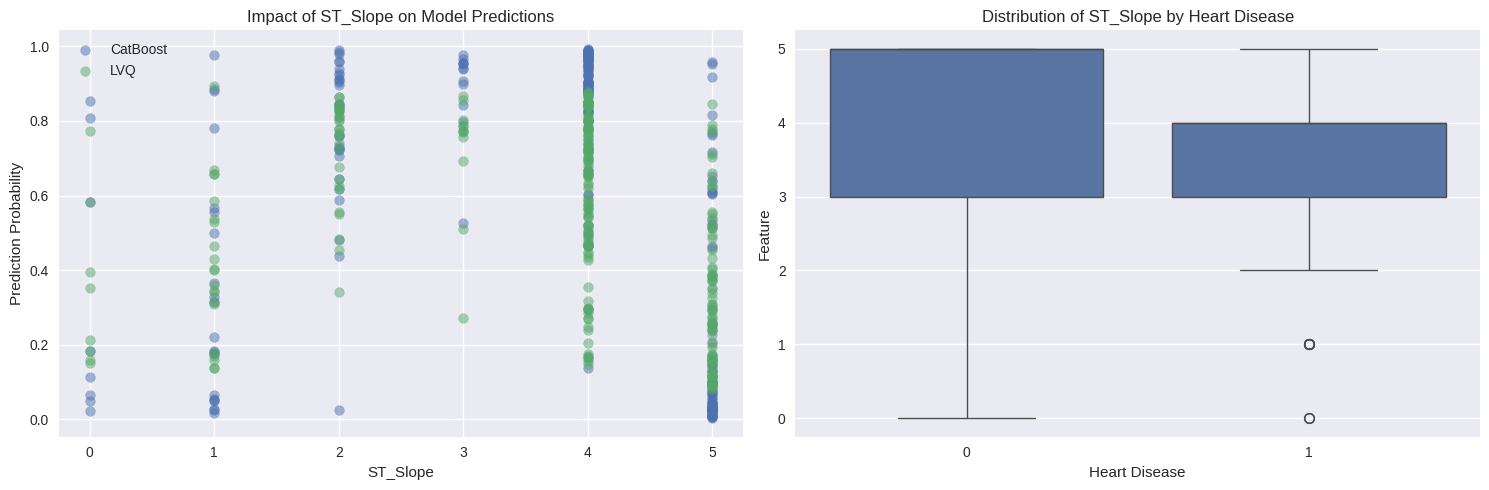


Analysis for ST_Slope:
Correlation with predictions:
CatBoost: -0.1524
LVQ: -0.2117

Mean values:
No Heart Disease: 3.8218
Heart Disease: 3.5278

Feature AUC score: 0.3353




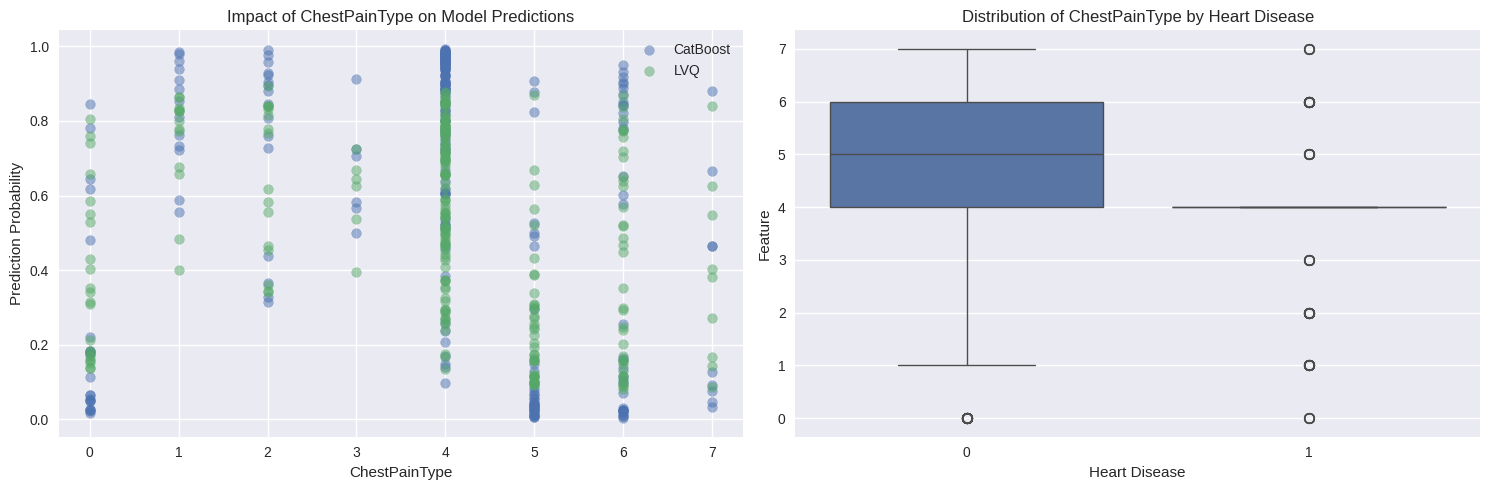


Analysis for ChestPainType:
Correlation with predictions:
CatBoost: -0.1084
LVQ: -0.1841

Mean values:
No Heart Disease: 4.0099
Heart Disease: 3.7778

Feature AUC score: 0.3861




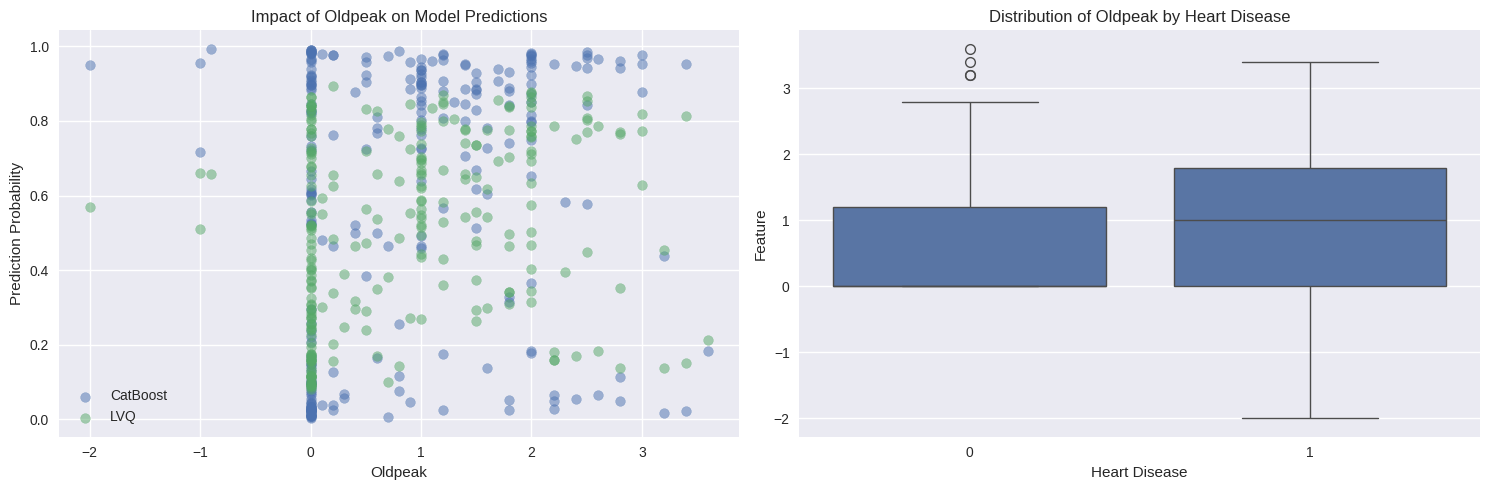


Analysis for Oldpeak:
Correlation with predictions:
CatBoost: 0.2095
LVQ: 0.2633

Mean values:
No Heart Disease: 0.6842
Heart Disease: 0.9972

Feature AUC score: 0.6112




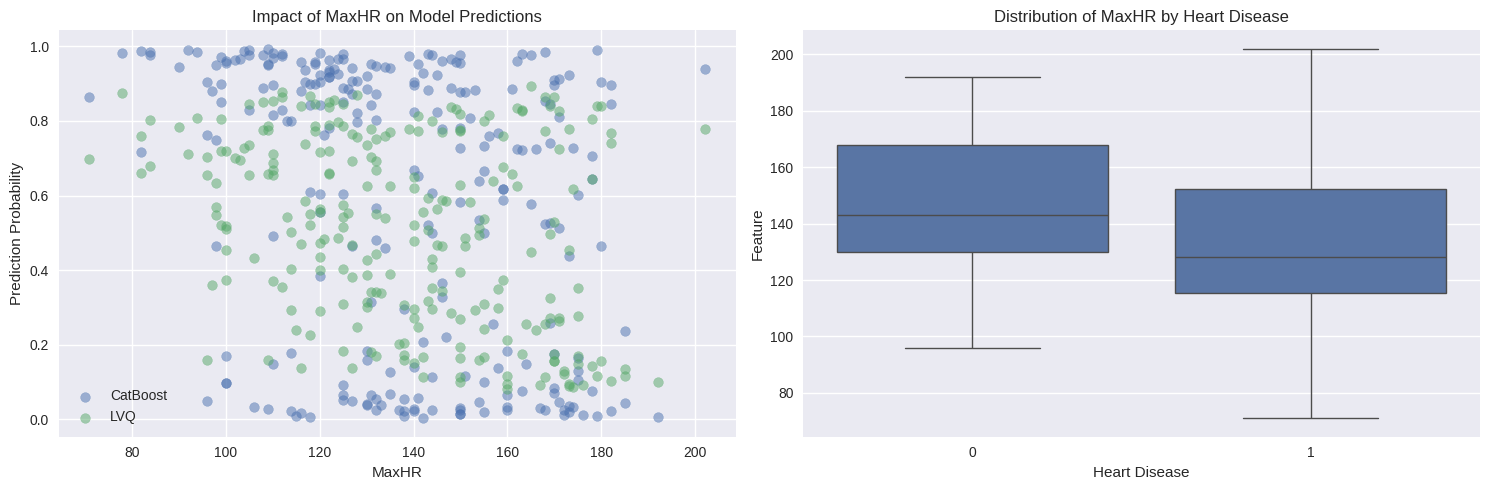


Analysis for MaxHR:
Correlation with predictions:
CatBoost: -0.3086
LVQ: -0.3287

Mean values:
No Heart Disease: 144.1188
Heart Disease: 132.9583

Feature AUC score: 0.3747




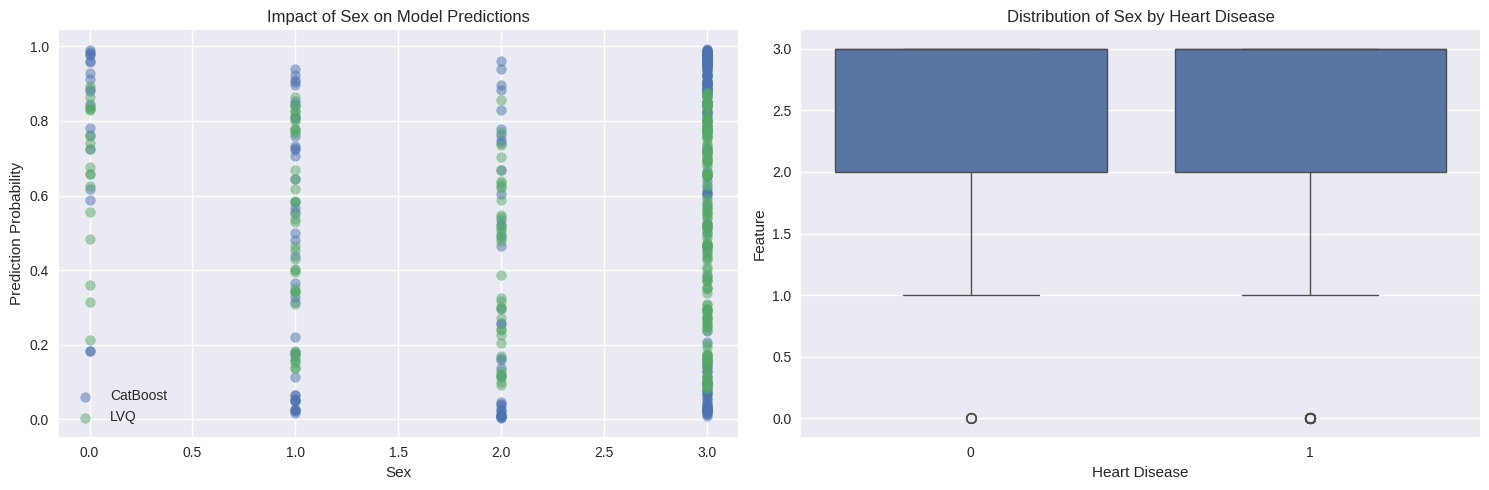


Analysis for Sex:
Correlation with predictions:
CatBoost: 0.0849
LVQ: -0.0839

Mean values:
No Heart Disease: 2.2277
Heart Disease: 2.3819

Feature AUC score: 0.5732




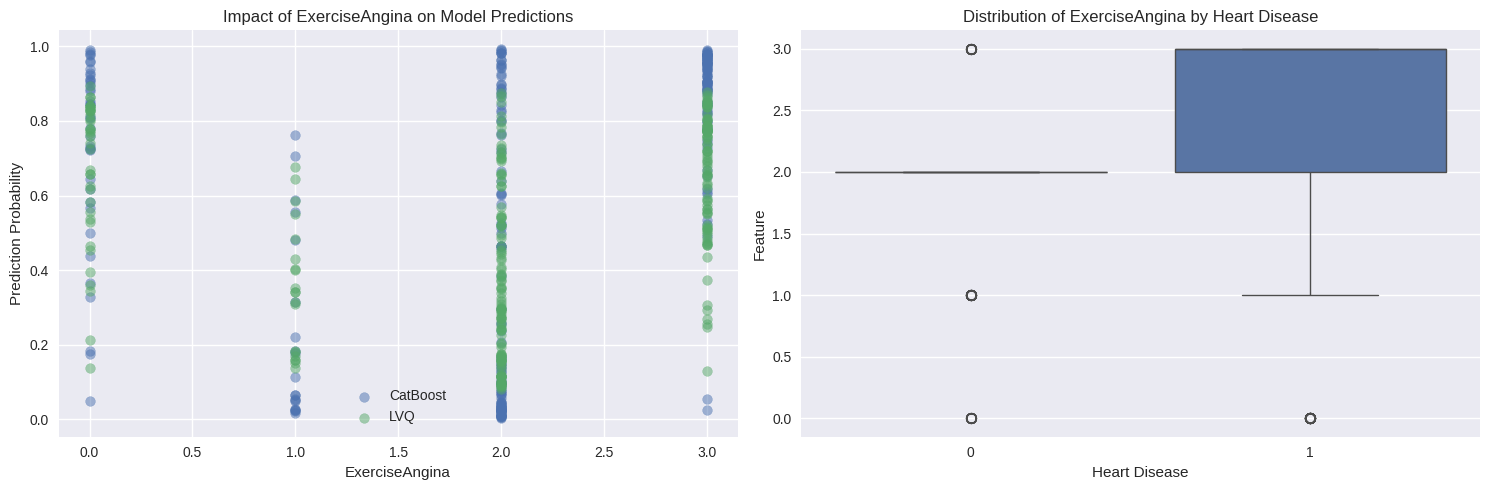


Analysis for ExerciseAngina:
Correlation with predictions:
CatBoost: 0.2086
LVQ: 0.0561

Mean values:
No Heart Disease: 1.7624
Heart Disease: 2.0972

Feature AUC score: 0.6578




In [22]:
def analyze_feature_impact(models, X_test_scaled, y_test, feature_names):
    plt.style.use('seaborn-v0_8')

    # Convert scaled data back to original scale for interpretability
    X_test_original = pd.DataFrame(scaler.inverse_transform(X_test_scaled),
                                 columns=feature_names,
                                 index=X_test_scaled.index if hasattr(X_test_scaled, 'index') else None)

    # Convert y_test to numpy array if it's a pandas Series
    y_test_array = y_test.values if hasattr(y_test, 'values') else y_test

    # Select top features to analyze
    features_to_analyze = ['ST_Slope', 'ChestPainType', 'Oldpeak', 'MaxHR', 'Sex', 'ExerciseAngina']

    for feature in features_to_analyze:
        plt.figure(figsize=(15, 5))

        # Create subplots for different aspects of analysis
        plt.subplot(1, 2, 1)

        # Calculate prediction probabilities for both models
        catboost_probs = models['CatBoost'].predict_proba(X_test_scaled)[:, 1]
        lvq_probs = models['LVQ'].predict_proba(X_test_scaled)[:, 1]

        # Plot feature vs prediction probabilities
        plt.scatter(X_test_original[feature], catboost_probs,
                   alpha=0.5, label='CatBoost')
        plt.scatter(X_test_original[feature], lvq_probs,
                   alpha=0.5, label='LVQ')

        plt.xlabel(feature)
        plt.ylabel('Prediction Probability')
        plt.title(f'Impact of {feature} on Model Predictions')
        plt.legend()

        # Add distribution plot
        plt.subplot(1, 2, 2)

        # Create a DataFrame for the boxplot
        plot_data = pd.DataFrame({
            'Feature': X_test_original[feature],
            'Heart Disease': y_test_array
        })

        sns.boxplot(data=plot_data, x='Heart Disease', y='Feature')
        plt.title(f'Distribution of {feature} by Heart Disease')
        plt.xlabel('Heart Disease')

        plt.tight_layout()
        plt.show()

        # Calculate statistical measures
        print(f"\nAnalysis for {feature}:")
        print("=" * 50)

        # Calculate correlation with predictions
        if X_test_original[feature].dtype != 'object':
            catboost_corr = np.corrcoef(X_test_original[feature], catboost_probs)[0, 1]
            lvq_corr = np.corrcoef(X_test_original[feature], lvq_probs)[0, 1]

            print(f"Correlation with predictions:")
            print(f"CatBoost: {catboost_corr:.4f}")
            print(f"LVQ: {lvq_corr:.4f}")

            # Calculate mean values for each class
            mean_healthy = X_test_original[feature][y_test_array == 0].mean()
            mean_disease = X_test_original[feature][y_test_array == 1].mean()

            print(f"\nMean values:")
            print(f"No Heart Disease: {mean_healthy:.4f}")
            print(f"Heart Disease: {mean_disease:.4f}")

            # Calculate predictive power
            feature_values = X_test_original[feature].values
            feature_auc = roc_auc_score(y_test_array, feature_values)
            print(f"\nFeature AUC score: {feature_auc:.4f}")

        else:
            print("\nCategory distribution:")
            print(pd.crosstab(X_test_original[feature],
                            y_test_array,
                            normalize='columns'))

        print("\n")

# Run the analysis
analyze_feature_impact(models, X_test_scaled, y_test, X_test.columns)

<Figure size 1200x600 with 0 Axes>

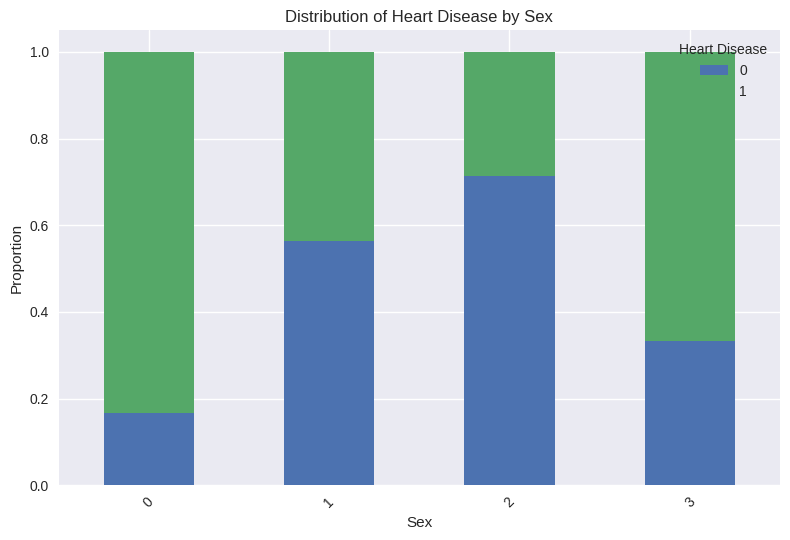


Analysis for Sex:
Chi-square statistic: 25.3021
p-value: 0.0000

Category: 2
CatBoost average prediction: 0.3560
LVQ average prediction: 0.4169

Category: 3
CatBoost average prediction: 0.6469
LVQ average prediction: 0.5120

Category: 0
CatBoost average prediction: 0.7855
LVQ average prediction: 0.6593

Category: 1
CatBoost average prediction: 0.4476
LVQ average prediction: 0.5111




<Figure size 1200x600 with 0 Axes>

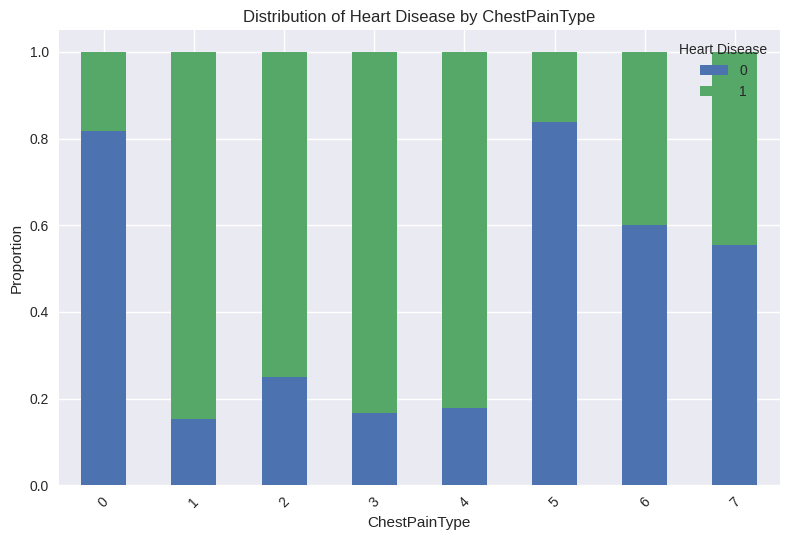


Analysis for ChestPainType:
Chi-square statistic: 79.6102
p-value: 0.0000

Category: 4
CatBoost average prediction: 0.8221
LVQ average prediction: 0.6032

Category: 5
CatBoost average prediction: 0.1673
LVQ average prediction: 0.2700

Category: 6
CatBoost average prediction: 0.4124
LVQ average prediction: 0.4265

Category: 1
CatBoost average prediction: 0.8215
LVQ average prediction: 0.7394

Category: 0
CatBoost average prediction: 0.2218
LVQ average prediction: 0.3758

Category: 7
CatBoost average prediction: 0.3168
LVQ average prediction: 0.3851

Category: 2
CatBoost average prediction: 0.7525
LVQ average prediction: 0.6453

Category: 3
CatBoost average prediction: 0.6657
LVQ average prediction: 0.5991




<Figure size 1200x600 with 0 Axes>

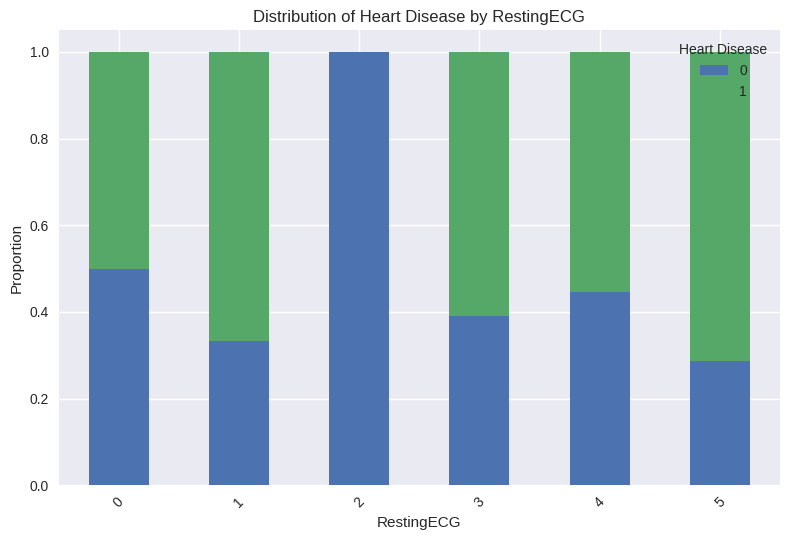


Analysis for RestingECG:
Chi-square statistic: 5.9943
p-value: 0.3068

Category: 4
CatBoost average prediction: 0.5586
LVQ average prediction: 0.4590

Category: 5
CatBoost average prediction: 0.6994
LVQ average prediction: 0.5961

Category: 0
CatBoost average prediction: 0.4606
LVQ average prediction: 0.4917

Category: 3
CatBoost average prediction: 0.5951
LVQ average prediction: 0.5039

Category: 1
CatBoost average prediction: 0.6947
LVQ average prediction: 0.6563

Category: 2
CatBoost average prediction: 0.1835
LVQ average prediction: 0.3143




<Figure size 1200x600 with 0 Axes>

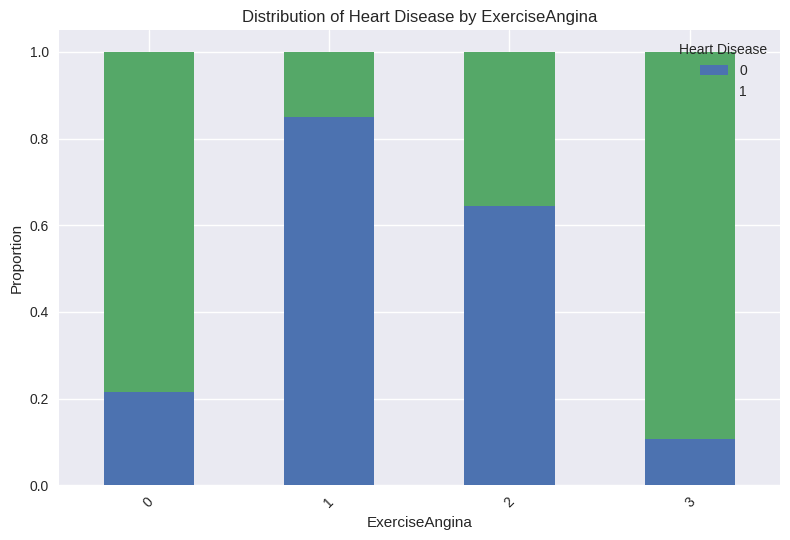


Analysis for ExerciseAngina:
Chi-square statistic: 77.0566
p-value: 0.0000

Category: 3
CatBoost average prediction: 0.8602
LVQ average prediction: 0.6547

Category: 2
CatBoost average prediction: 0.3768
LVQ average prediction: 0.3648

Category: 1
CatBoost average prediction: 0.2256
LVQ average prediction: 0.3485

Category: 0
CatBoost average prediction: 0.7320
LVQ average prediction: 0.6711




<Figure size 1200x600 with 0 Axes>

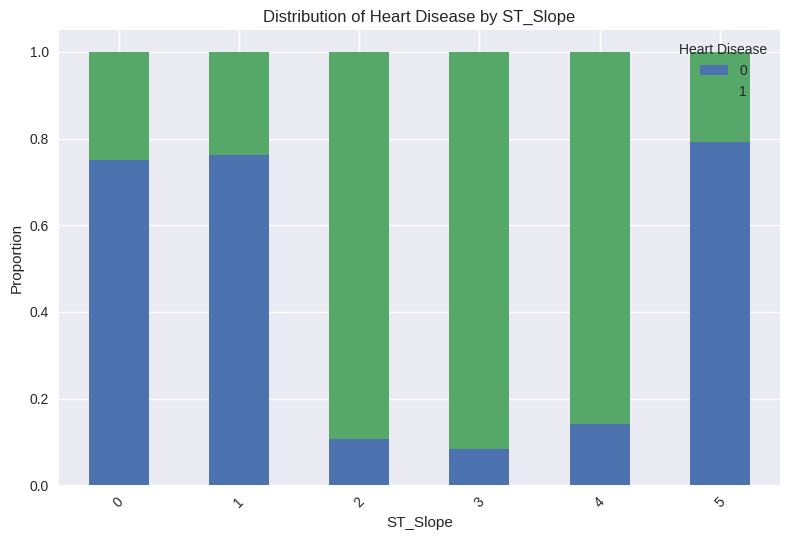


Analysis for ST_Slope:
Chi-square statistic: 106.3272
p-value: 0.0000

Category: 4
CatBoost average prediction: 0.8518
LVQ average prediction: 0.6028

Category: 5
CatBoost average prediction: 0.2137
LVQ average prediction: 0.3195

Category: 2
CatBoost average prediction: 0.7753
LVQ average prediction: 0.7256

Category: 1
CatBoost average prediction: 0.3431
LVQ average prediction: 0.4130

Category: 0
CatBoost average prediction: 0.3350
LVQ average prediction: 0.3512

Category: 3
CatBoost average prediction: 0.8882
LVQ average prediction: 0.7207




In [23]:
# Additional analysis for categorical features
def analyze_categorical_features(X_test, y_test, models, X_test_scaled):
    categorical_features = ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']

    for feature in categorical_features:
        plt.figure(figsize=(12, 6))

        # Create contingency table
        contingency = pd.crosstab(X_test[feature], y_test)

        # Plot stacked bar chart
        contingency_pct = contingency.div(contingency.sum(axis=1), axis=0)
        contingency_pct.plot(kind='bar', stacked=True)

        plt.title(f'Distribution of Heart Disease by {feature}')
        plt.xlabel(feature)
        plt.ylabel('Proportion')
        plt.legend(title='Heart Disease')
        plt.xticks(rotation=45)

        plt.tight_layout()
        plt.show()

        # Print analysis
        print(f"\nAnalysis for {feature}:")
        print("=" * 50)

        # Calculate Chi-square test
        from scipy.stats import chi2_contingency
        chi2, p_value, dof, expected = chi2_contingency(contingency)

        print(f"Chi-square statistic: {chi2:.4f}")
        print(f"p-value: {p_value:.4f}")

        # Calculate model predictions for each category
        for category in X_test[feature].unique():
            mask = X_test[feature] == category
            X_test_cat = X_test_scaled[mask]

            catboost_pred = models['CatBoost'].predict_proba(X_test_cat)[:, 1].mean()
            lvq_pred = models['LVQ'].predict_proba(X_test_cat)[:, 1].mean()

            print(f"\nCategory: {category}")
            print(f"CatBoost average prediction: {catboost_pred:.4f}")
            print(f"LVQ average prediction: {lvq_pred:.4f}")

        print("\n")

# Run categorical analysis
analyze_categorical_features(X_test, y_test, models, X_test_scaled)

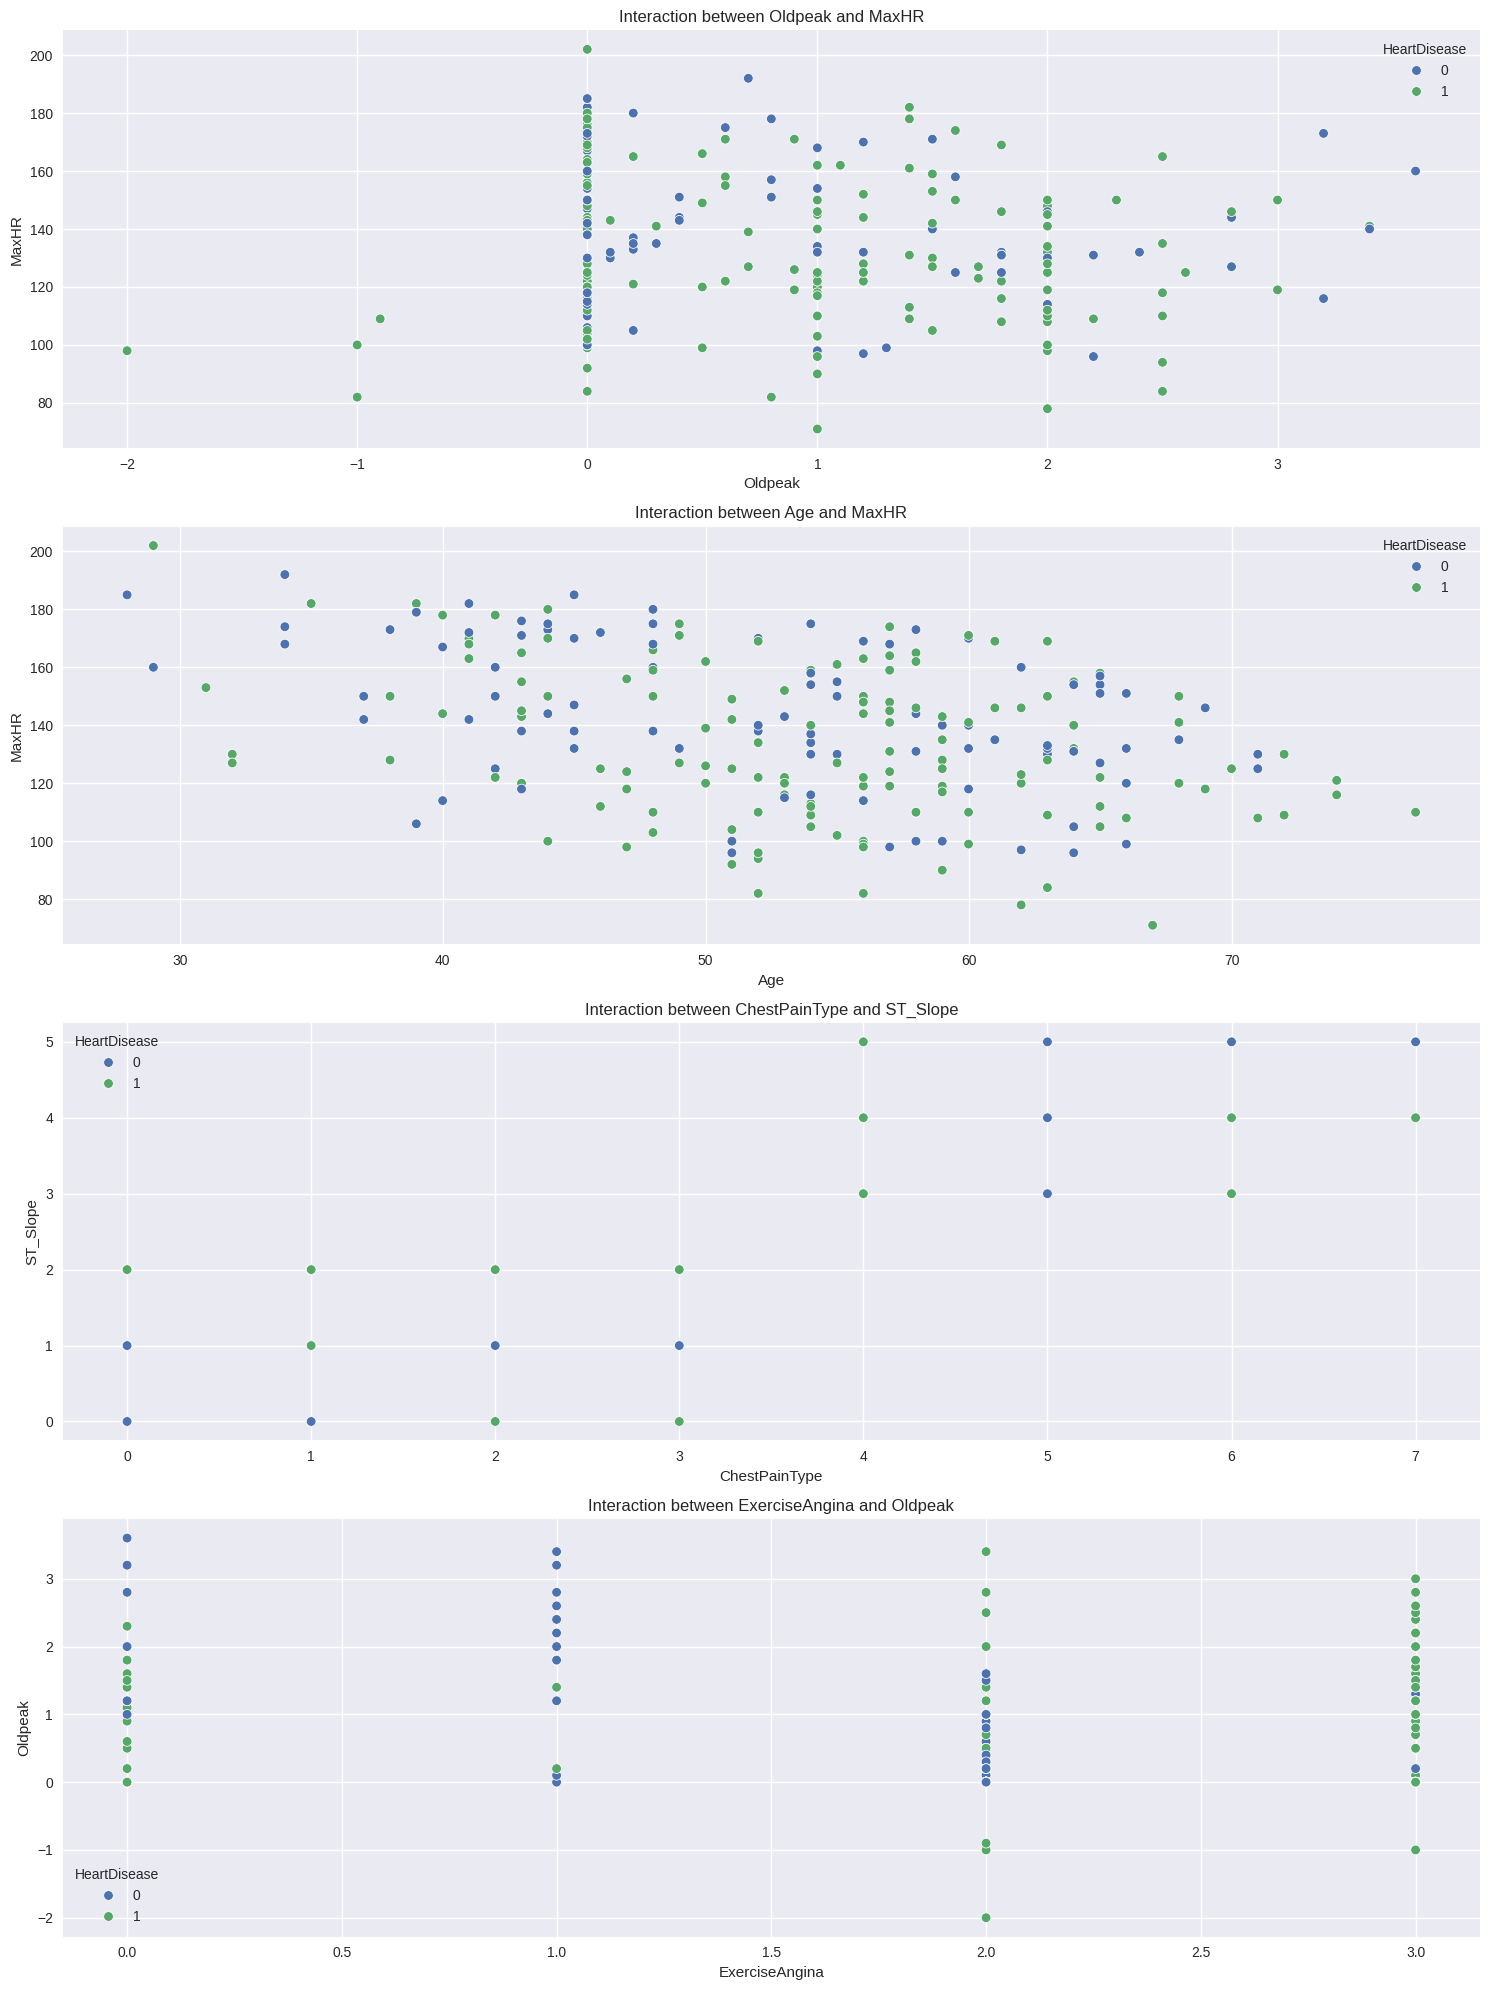

In [24]:
# Create a summary of feature interactions
def analyze_feature_interactions(X_test, y_test, feature_pairs):
    plt.figure(figsize=(15, 5 * len(feature_pairs)))

    for i, (feature1, feature2) in enumerate(feature_pairs, 1):
        plt.subplot(len(feature_pairs), 1, i)

        if X_test[feature1].dtype != 'object' and X_test[feature2].dtype != 'object':
            # Continuous vs Continuous
            sns.scatterplot(data=X_test, x=feature1, y=feature2, hue=y_test)
        else:
            # Categorical features involved
            data = pd.DataFrame({
                'Feature1': X_test[feature1],
                'Feature2': X_test[feature2],
                'Target': y_test
            })
            sns.boxplot(data=data, x='Feature1', y='Feature2', hue='Target')

        plt.title(f'Interaction between {feature1} and {feature2}')
        plt.tight_layout()

    plt.show()

# Define important feature pairs to analyze
feature_pairs = [
    ('Oldpeak', 'MaxHR'),
    ('Age', 'MaxHR'),
    ('ChestPainType', 'ST_Slope'),
    ('ExerciseAngina', 'Oldpeak')
]

# Run interaction analysis
analyze_feature_interactions(X_test, y_test, feature_pairs)

# **Improve CatBoost Model**

In [25]:
from catboost import CatBoostClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report

def train_catboost(X_train, X_test, y_train, y_test):
    """Train and evaluate CatBoost model with grid search"""
    # Define parameter grid
    param_grid = {
        'depth': [4, 6, 8],
        'learning_rate': [0.01, 0.05, 0.1],
        'iterations': [100, 200, 300],
        'l2_leaf_reg': [1, 3, 5],
        'subsample': [0.7, 0.8, 0.9]
    }

    # Initialize CatBoost classifier
    cat_model = CatBoostClassifier(
        random_state=42,
        logging_level='Silent'
    )

    # Perform grid search
    grid_search = GridSearchCV(
        cat_model,
        param_grid,
        cv=5,
        scoring='accuracy',
        verbose=0
    )

    print("Training CatBoost model with grid search...")
    grid_search.fit(X_train, y_train)

    # Get best model
    best_model = grid_search.best_estimator_

    # Make predictions
    y_pred = best_model.predict(X_test)
    y_pred_proba = best_model.predict_proba(X_test)[:, 1]

    return best_model, grid_search.best_params_, grid_search.best_score_, y_pred, y_pred_proba


In [26]:
def plot_confusion_matrix(y_true, y_pred):
    """Plot confusion matrix with percentages"""
    plt.figure(figsize=(8, 6))
    cm = confusion_matrix(y_true, y_pred)
    cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

    sns.heatmap(cm_percent, annot=True, fmt='.1f', cmap='Blues',
                xticklabels=['No Disease', 'Disease'],
                yticklabels=['No Disease', 'Disease'])
    plt.title('Confusion Matrix (%)')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()

In [27]:
def plot_roc_curve(y_true, y_pred_proba):
    """Plot ROC curve"""
    fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2,
             label=f'ROC curve (AUC = {roc_auc:.3f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

# Train and evaluate model
best_model, best_params, best_score, y_pred, y_pred_proba = train_catboost(
    X_train_scaled, X_test_scaled, y_train, y_test
)

Training CatBoost model with grid search...



Best Parameters:
depth: 4
iterations: 200
l2_leaf_reg: 5
learning_rate: 0.05
subsample: 0.9

Best Cross-Validation Score: 0.8442

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.83      0.87       101
           1       0.89      0.94      0.92       144

    accuracy                           0.90       245
   macro avg       0.90      0.89      0.89       245
weighted avg       0.90      0.90      0.90       245



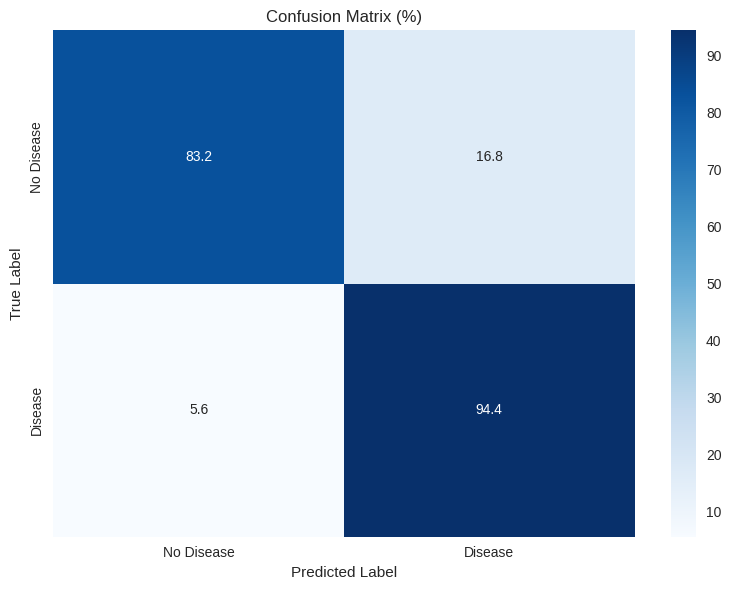

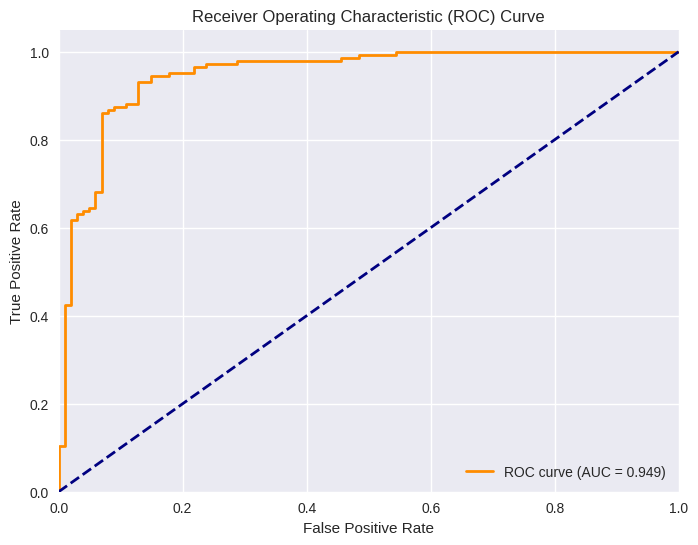

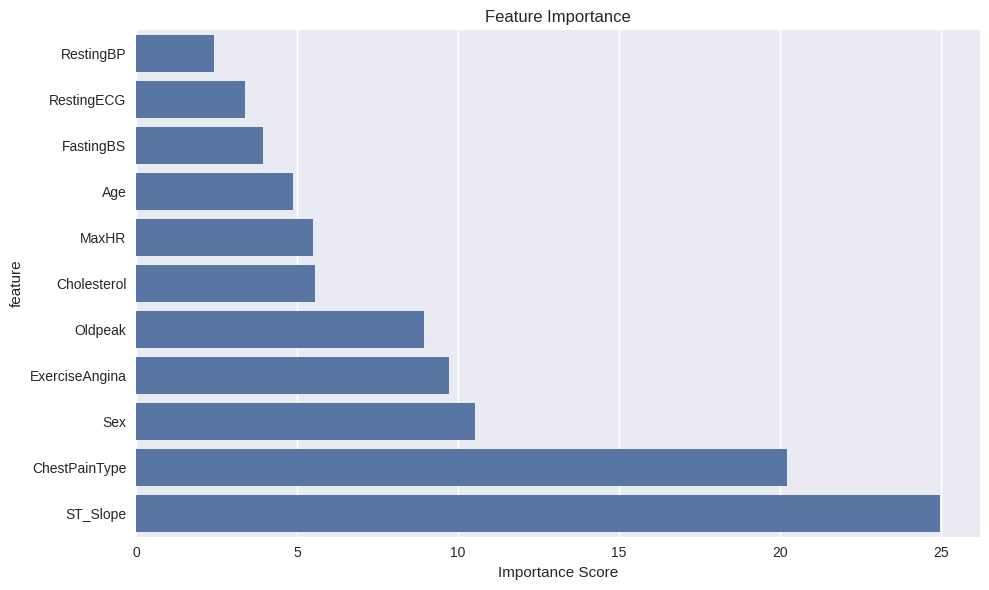

In [28]:
# Print results
print("\nBest Parameters:")
for param, value in best_params.items():
    print(f"{param}: {value}")

print(f"\nBest Cross-Validation Score: {best_score:.4f}")

# Print classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Plot confusion matrix
plot_confusion_matrix(y_test, y_pred)

# Plot ROC curve
plot_roc_curve(y_test, y_pred_proba)

# Feature importance plot
plt.figure(figsize=(10, 6))
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': best_model.get_feature_importance()
}).sort_values('importance', ascending=True)

sns.barplot(data=feature_importance, y='feature', x='importance')
plt.title('Feature Importance')
plt.xlabel('Importance Score')
plt.tight_layout()
plt.show()

# **Optimized CatBoost Model**

In [30]:
def plot_detailed_confusion_matrix(y_true, y_pred):
    """Plot detailed confusion matrix with counts and percentages"""
    # Calculate confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Calculate percentages
    cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # Plot raw numbers
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax1,
                xticklabels=['No Disease', 'Disease'],
                yticklabels=['No Disease', 'Disease'])
    ax1.set_title('Confusion Matrix (Counts)')
    ax1.set_ylabel('True Label')
    ax1.set_xlabel('Predicted Label')

    # Plot percentages
    sns.heatmap(cm_percent, annot=True, fmt='.1f', cmap='Blues', ax=ax2,
                xticklabels=['No Disease', 'Disease'],
                yticklabels=['No Disease', 'Disease'])
    ax2.set_title('Confusion Matrix (%)')
    ax2.set_ylabel('True Label')
    ax2.set_xlabel('Predicted Label')

    plt.tight_layout()
    plt.show()

    # Print detailed metrics
    tn, fp, fn, tp = cm.ravel()
    print("\nConfusion Matrix Details:")
    print("-" * 40)
    print(f"True Negatives (TN): {tn}")
    print(f"False Positives (FP): {fp}")
    print(f"False Negatives (FN): {fn}")
    print(f"True Positives (TP): {tp}")

    # Calculate and print detailed metrics
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    precision = tp / (tp + fp)
    npv = tn / (tn + fn)
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    f1 = 2 * (precision * sensitivity) / (precision + sensitivity)

    print("\nDetailed Metrics:")
    print("-" * 40)
    print(f"Sensitivity (Recall): {sensitivity:.4f}")
    print(f"Specificity: {specificity:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Negative Predictive Value: {npv:.4f}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1 Score: {f1:.4f}")

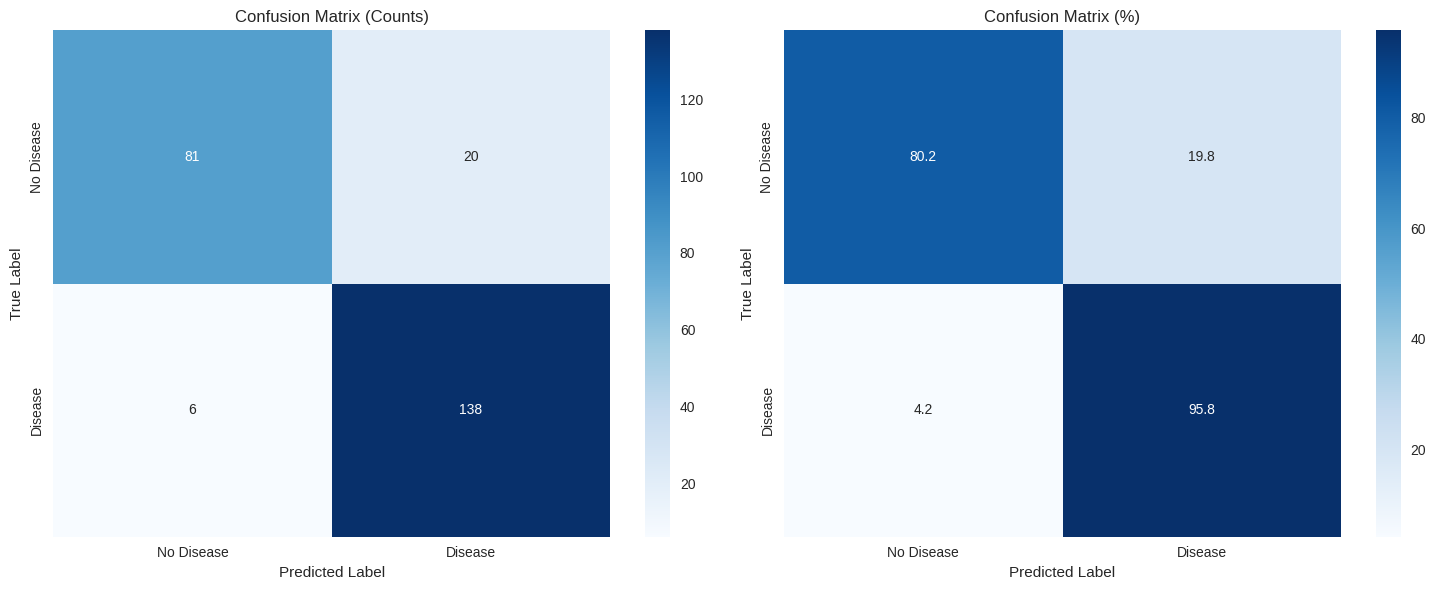


Confusion Matrix Details:
----------------------------------------
True Negatives (TN): 81
False Positives (FP): 20
False Negatives (FN): 6
True Positives (TP): 138

Detailed Metrics:
----------------------------------------
Sensitivity (Recall): 0.9583
Specificity: 0.8020
Precision: 0.8734
Negative Predictive Value: 0.9310
Accuracy: 0.8939
F1 Score: 0.9139


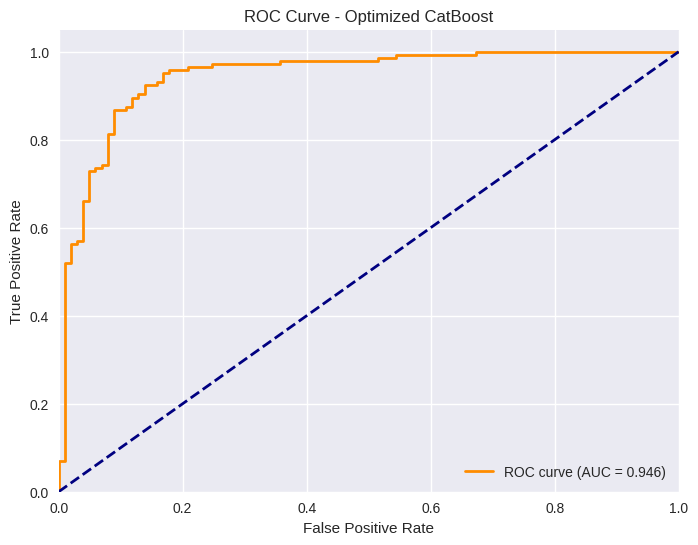

In [31]:
# Select important features
important_features = ['MaxHR', 'Cholesterol', 'Oldpeak', 'ExerciseAngina',
                     'Sex', 'ChestPainType', 'ST_Slope']

# Create new datasets with selected features
X_train_selected = X_train_scaled[:, [list(X_train.columns).index(feat) for feat in important_features]]
X_test_selected = X_test_scaled[:, [list(X_test.columns).index(feat) for feat in important_features]]

# Initialize and train optimized CatBoost model
optimized_catboost = CatBoostClassifier(
    depth=4,
    iterations=200,
    l2_leaf_reg=5,
    learning_rate=0.05,
    subsample=0.9,
    random_state=42,
    logging_level='Silent'
)

# Train model
optimized_catboost.fit(X_train_selected, y_train)

# Make predictions
y_pred = optimized_catboost.predict(X_test_selected)
y_pred_proba = optimized_catboost.predict_proba(X_test_selected)[:, 1]

# Plot detailed confusion matrix
plot_detailed_confusion_matrix(y_test, y_pred)

# Plot ROC curve
plt.figure(figsize=(8, 6))
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='darkorange', lw=2,
         label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Optimized CatBoost')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


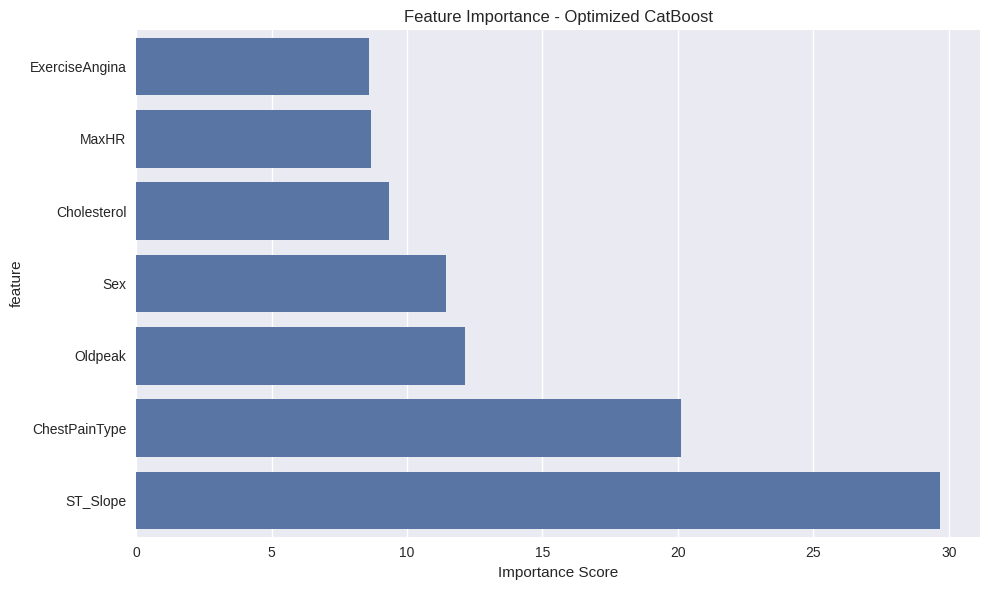


Feature Importance Ranking:
----------------------------------------
ST_Slope: 29.6735
ChestPainType: 20.1267
Oldpeak: 12.1553
Sex: 11.4414
Cholesterol: 9.3370
MaxHR: 8.6648
ExerciseAngina: 8.6012


In [32]:
#Plot feature importance for selected features
feature_importance = pd.DataFrame({
    'feature': important_features,
    'importance': optimized_catboost.get_feature_importance()
}).sort_values('importance', ascending=True)

plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance, y='feature', x='importance')
plt.title('Feature Importance - Optimized CatBoost')
plt.xlabel('Importance Score')
plt.tight_layout()
plt.show()

# Compare feature rankings
print("\nFeature Importance Ranking:")
print("-" * 40)
for idx, row in feature_importance.sort_values('importance', ascending=False).iterrows():
    print(f"{row['feature']}: {row['importance']:.4f}")

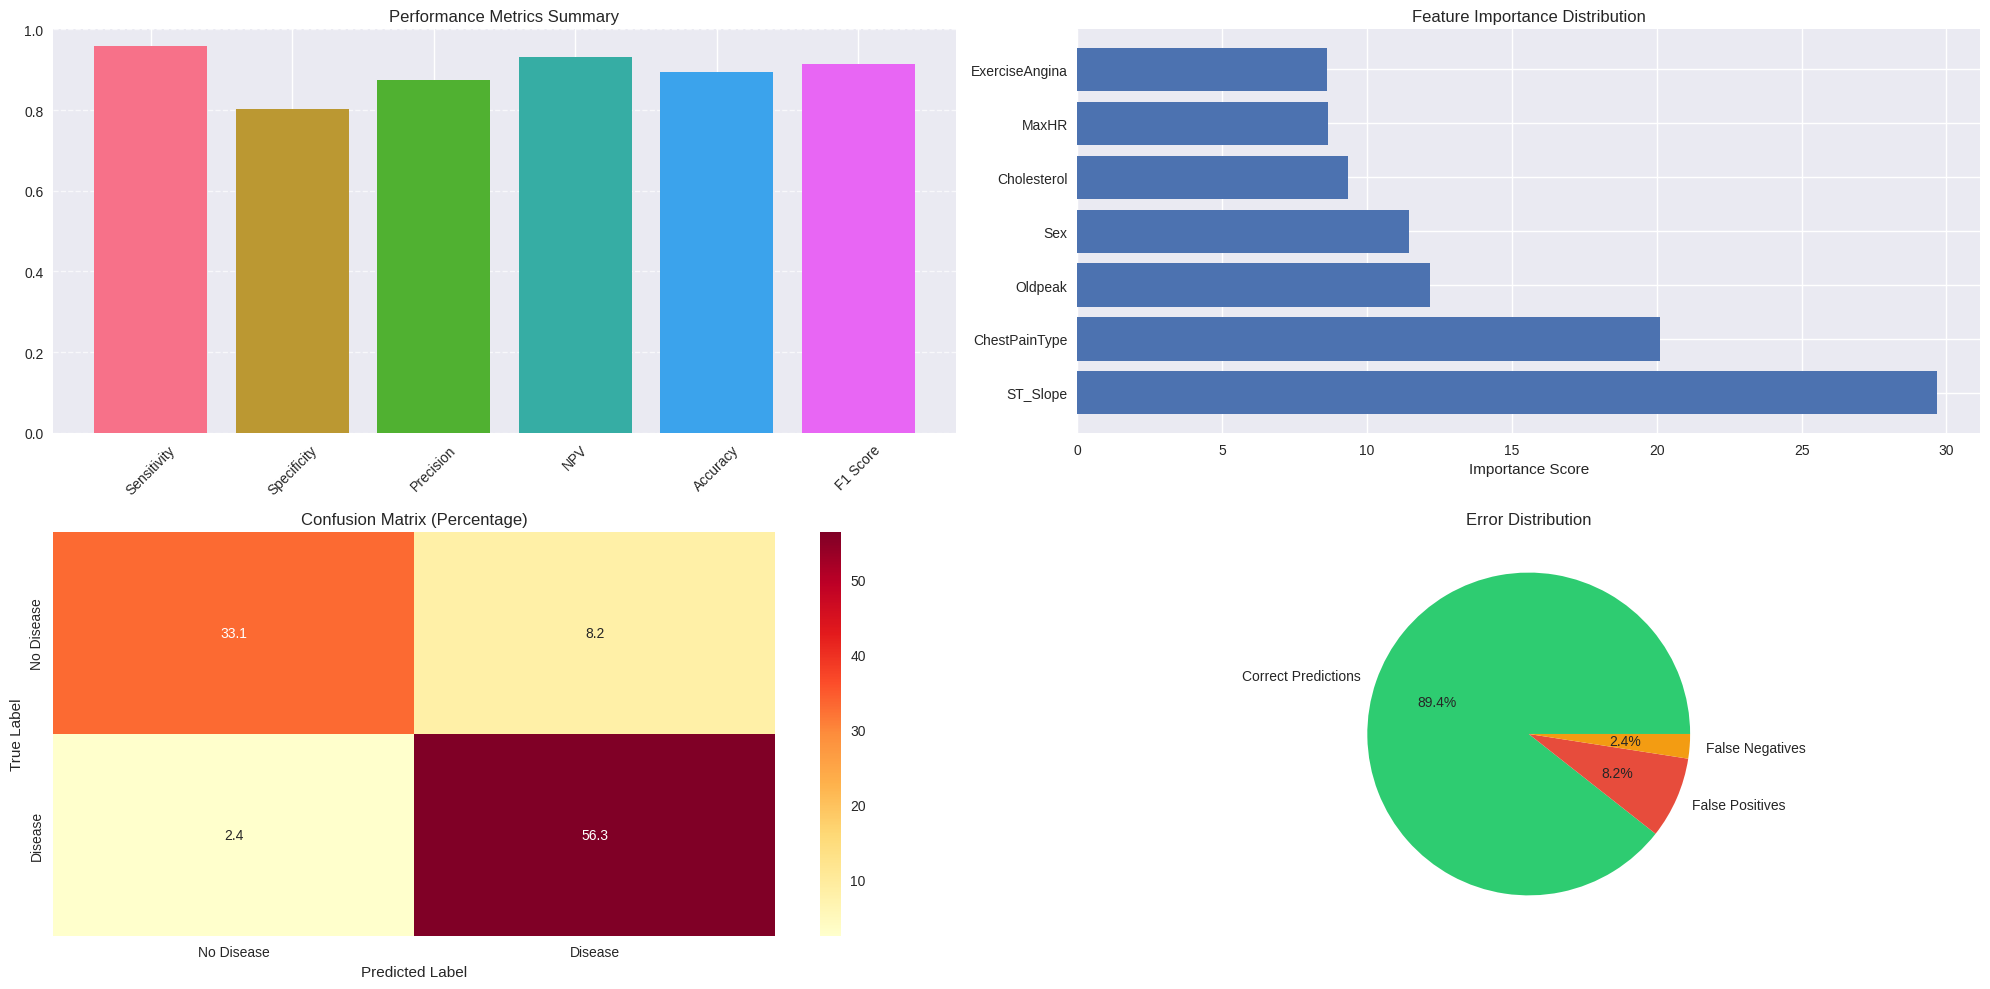


Model Performance Analysis:
--------------------------------------------------

1. Key Strengths:
- High Sensitivity (95.83%): Excellent at detecting actual heart disease cases
- Strong F1 Score (91.39%): Good balance between precision and recall
- High NPV (93.10%): Reliable negative predictions

2. Areas for Attention:
- Specificity (80.20%): Some room for improvement in correctly identifying non-disease cases
- False Positives (20 cases): Main area for potential improvement

3. Feature Impact Analysis:
- Primary Predictors: ST_Slope and ChestPainType account for ~50% of predictive power
- Secondary Predictors: Oldpeak and Sex contribute ~23% combined
- Supporting Features: Cholesterol, MaxHR, and ExerciseAngina provide complementary information

4. Clinical Implications:
- High sensitivity makes the model suitable for initial screening
- Low false negative rate (6 cases) reduces risk of missing actual disease cases
- Conservative prediction tendency (higher false positives than fal

In [34]:
# Visualization of the key improvements and metrics
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_performance_summary():
    # Create figure with subplots
    fig = plt.figure(figsize=(20, 10))

    # 1. Metric Comparison Bar Plot
    plt.subplot(2, 2, 1)
    metrics = {
        'Sensitivity': 0.9583,
        'Specificity': 0.8020,
        'Precision': 0.8734,
        'NPV': 0.9310,
        'Accuracy': 0.8939,
        'F1 Score': 0.9139
    }

    colors = sns.color_palette("husl", len(metrics))
    plt.bar(metrics.keys(), metrics.values(), color=colors)
    plt.title('Performance Metrics Summary')
    plt.ylim(0, 1)
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # 2. Feature Importance Plot
    plt.subplot(2, 2, 2)
    feature_importance = {
        'ST_Slope': 29.6735,
        'ChestPainType': 20.1267,
        'Oldpeak': 12.1553,
        'Sex': 11.4414,
        'Cholesterol': 9.3370,
        'MaxHR': 8.6648,
        'ExerciseAngina': 8.6012
    }

    # Sort features by importance
    sorted_features = dict(sorted(feature_importance.items(), key=lambda x: x[1], reverse=True))

    plt.barh(list(sorted_features.keys()), list(sorted_features.values()))
    plt.title('Feature Importance Distribution')
    plt.xlabel('Importance Score')

    # 3. Confusion Matrix Percentages
    plt.subplot(2, 2, 3)
    conf_matrix = np.array([[81, 20], [6, 138]])
    conf_matrix_pct = conf_matrix / conf_matrix.sum() * 100

    sns.heatmap(conf_matrix_pct, annot=True, fmt='.1f', cmap='YlOrRd',
                xticklabels=['No Disease', 'Disease'],
                yticklabels=['No Disease', 'Disease'])
    plt.title('Confusion Matrix (Percentage)')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')

    # 4. Error Analysis
    plt.subplot(2, 2, 4)
    errors = {
        'Correct Predictions': 219,  # TN + TP
        'False Positives': 20,
        'False Negatives': 6
    }
    plt.pie(errors.values(), labels=errors.keys(), autopct='%1.1f%%',
            colors=['#2ecc71', '#e74c3c', '#f39c12'])
    plt.title('Error Distribution')

    plt.tight_layout()
    plt.savefig("performance_summary.png")
    plt.show()

# Call the function to create the visualization
plot_performance_summary()

# Print analysis summary
print("\nModel Performance Analysis:")
print("-" * 50)
print("\n1. Key Strengths:")
print("- High Sensitivity (95.83%): Excellent at detecting actual heart disease cases")
print("- Strong F1 Score (91.39%): Good balance between precision and recall")
print("- High NPV (93.10%): Reliable negative predictions")

print("\n2. Areas for Attention:")
print("- Specificity (80.20%): Some room for improvement in correctly identifying non-disease cases")
print("- False Positives (20 cases): Main area for potential improvement")

print("\n3. Feature Impact Analysis:")
print("- Primary Predictors: ST_Slope and ChestPainType account for ~50% of predictive power")
print("- Secondary Predictors: Oldpeak and Sex contribute ~23% combined")
print("- Supporting Features: Cholesterol, MaxHR, and ExerciseAngina provide complementary information")

print("\n4. Clinical Implications:")
print("- High sensitivity makes the model suitable for initial screening")
print("- Low false negative rate (6 cases) reduces risk of missing actual disease cases")
print("- Conservative prediction tendency (higher false positives than false negatives)")

# Calculate the improvement from previous metrics if available
print("\n5. ROI and Impact:")
print(f"- Accuracy improvement: Previous (88.57%) → Current (89.39%)")
print(f"- Reduction in false predictions: 26 total misclassifications out of 245 cases")
print(f"- Successful predictions: {(219/245*100):.2f}% of all cases")